# Graph Construction & Structural Attention Analysis

datasets and bipartite graphs for 1996-2000 and 2018-2022

## libraries

In [38]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import os
import math
from collections import Counter
import re



## Load data

In [39]:

# 1. Load original CSVs
ratings = pd.read_csv("../data/ml-latest/ratings.csv")   # userId, movieId, rating, timestamp
movies  = pd.read_csv("../data/ml-latest/movies.csv")    # movieId, title, genres
tags    = pd.read_csv("../data/ml-latest/tags.csv")      # userId, movieId, tag, timestamp
links   = pd.read_csv("../data/ml-latest/links.csv")     # movieId, imdbId, tmdbId

# 2. Convert Unix timestamp (seconds since epoch) to datetime
#    If your timestamp is already datetime, you can skip this step.
ratings["datetime"] = pd.to_datetime(ratings["timestamp"], unit="s")
tags["datetime"]    = pd.to_datetime(tags["timestamp"], unit="s")


### analysis

In [40]:
min_ts = ratings["timestamp"].min()
max_ts = ratings["timestamp"].max()

min_date = pd.to_datetime(min_ts, unit="s")
max_date = pd.to_datetime(max_ts, unit="s")

print("Oldest rating date:", min_date)
print("Newest rating date:", max_date)

Oldest rating date: 1995-01-09 11:46:44
Newest rating date: 2023-07-20 08:53:33


In [41]:
# how many reviews per year
ratings['year'] = ratings['datetime'].dt.year
reviews_per_year = ratings.groupby('year').size()
print("\nReviews per year:\n", reviews_per_year)



Reviews per year:
 year
1995          4
1996    1732721
1997     763613
1998     329419
1999    1230159
2000    2031258
2001    1237836
2002     909011
2003    1077389
2004    1199108
2005    1844381
2006    1207180
2007    1091850
2008    1202202
2009     978867
2010     967255
2011     819971
2012     779951
2013     621443
2014     566628
2015    1853975
2016    2005979
2017    1899523
2018    1455193
2019    1450218
2020    1763532
2021    1297525
2022     953347
2023     562624
dtype: int64


In [42]:
# how many user reviewed per year
users_per_year = ratings.groupby('year')['userId'].nunique()
print("\nUnique users per year:\n", users_per_year)



Unique users per year:
 year
1995        2
1996    34448
1997    16768
1998     6880
1999    14222
2000    25354
2001    16422
2002    11657
2003    11892
2004    10820
2005    15603
2006    12964
2007    13024
2008    15150
2009    15001
2010    16354
2011    15285
2012    14139
2013    11824
2014    10328
2015    23166
2016    20945
2017    19420
2018    17451
2019    16562
2020    19725
2021    16191
2022    12776
2023     9335
Name: userId, dtype: int64


In [43]:
# number of unique users
num_unique_users = ratings['userId'].nunique()
print("\nNumber of unique users:", num_unique_users)


Number of unique users: 330975


### Size of the datasets

In [44]:
def df_size_info(df, name):
    n_rows, n_cols = df.shape
    print(f"{name}:")
    print(f"  rows: {n_rows:,}")
    print(f"  columns: {n_cols}")

movie_tags = (
    tags
    .sort_values("timestamp")  # keep tags in chronological order
    .groupby("movieId")["tag"]
    .apply(lambda s: " | ".join(s.astype(str)))
    .reset_index()
)

df_size_info(ratings, "ratings")
df_size_info(movies,  "movies")
df_size_info(tags,    "tags")
df_size_info(links,   "links")

ratings:
  rows: 33,832,162
  columns: 6
movies:
  rows: 86,537
  columns: 3
tags:
  rows: 2,328,315
  columns: 5
links:
  rows: 86,537
  columns: 3


In [45]:
# number of reviews are between the period 1996-01-01 and 2000-12-31
start_date1 = pd.to_datetime("1996-01-01")
end_date1   = pd.to_datetime("2000-12-31")

mask1 = (ratings["datetime"] >= start_date1) & (ratings["datetime"] <= end_date1)
filtered_ratings1 = ratings.loc[mask1]
num_reviews_in_period1= filtered_ratings1.shape[0]
print(f"\nNumber of reviews between {start_date1.date()} and {end_date1.date()}: {num_reviews_in_period1}")


Number of reviews between 1996-01-01 and 2000-12-31: 6083034


In [46]:
# number of reviews are between the period 2018-01-01 and 2022-12-31
start_date2 = pd.to_datetime("2018-01-01")
end_date2   = pd.to_datetime("2022-12-31")

mask2 = (ratings["datetime"] >= start_date2) & (ratings["datetime"] <= end_date2)
filtered_ratings2 = ratings.loc[mask2]
num_reviews_in_period2 = filtered_ratings2.shape[0]
print(f"\nNumber of reviews between {start_date2.date()} and {end_date2.date()}: {num_reviews_in_period2}")


Number of reviews between 2018-01-01 and 2022-12-31: 6917880


### tags processing

In [47]:
tags.head()

userId  movieId            tag   timestamp            datetime
0      10      260   good vs evil  1430666558 2015-05-03 15:22:38
1      10      260  Harrison Ford  1430666505 2015-05-03 15:21:45
2      10      260         sci-fi  1430666538 2015-05-03 15:22:18
3      14     1221      Al Pacino  1311600756 2011-07-25 13:32:36
4      14     1221          mafia  1311600746 2011-07-25 13:32:26

In [48]:
tags_processed = (
    tags
    .groupby(["movieId", "userId"])["tag"]
    .apply(lambda s: " | ".join(s.astype(str))) # Join multiple tags with a pipe
    .reset_index()
)

In [49]:
tags_processed

movieId  userId                                                tag
0             1     499                      animation | friendship | toys
1             1    1114                  animation | Disney | Pixar | toys
2             1    1394                     CGI | classic | disney | pixar
3             1    2483                                      lots of heart
4             1    2612                                          Tom Hanks
...         ...     ...                                                ...
446206   288765  236602                           bad science | plot holes
446207   288779  185724                                 Don Camillo Series
446208   288849   95007                 addiction | animation | short film
446209   288937  292087                                              anime
446210   288955  308174  catalan | Costa brava | flatmate | Millennials...

[446211 rows x 3 columns]

### filtering

In [50]:
def get_cleaned_period_data(ratings_raw, start_year, end_year, min_user_ratings=20, min_movie_ratings=50):
    """
    Takes the RAW ratings dataframe, filters by a specific time period, and applies
    iterative K-Core cleaning (removing users/movies with low activity).
    
    Returns: A cleaned DataFrame ready for graph construction.
    """
    print(f"\n{'='*60}")
    print(f"🔄 PROCESSING PERIOD: {start_year} - {end_year}")
    print(f"{'='*60}")
    
    # --- STEP 1: TEMPORAL PREPROCESSING ---
    # Convert timestamp only if necessary (check if 'year' column exists)
    df = ratings_raw.copy()
    
    if 'year' not in df.columns:
        # Assuming timestamp is in seconds (unit='s')
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
        df['year'] = df['datetime'].dt.year
    
    # Filter by years
    df_period = df[(df['year'] >= start_year) & (df['year'] <= end_year)].copy()
    
    n_raw = len(df_period)
    u_raw = df_period['userId'].nunique()
    m_raw = df_period['movieId'].nunique()
    
    if n_raw == 0:
        print("❌ ALERT: No ratings found in this period.")
        return None

    print(f"📅 1. Temporal Filter ({start_year}-{end_year}):")
    print(f"   -> Ratings found:     {n_raw:,}")
    print(f"   -> Unique users:      {u_raw:,}")
    print(f"   -> Unique movies:     {m_raw:,}")
    
    # --- STEP 2: ITERATIVE K-CORE FILTERING ---
    print(f"\n🧹 2. K-Core Cleaning (Min User: {min_user_ratings}, Min Movie: {min_movie_ratings})...")
    
    df_core = df_period.copy()
    iteration = 0
    
    while True:
        iteration += 1
        shape_start = df_core.shape[0]
        
        # A. Count frequencies
        user_counts = df_core['userId'].value_counts()
        movie_counts = df_core['movieId'].value_counts()
        
        # B. Identify valid nodes
        valid_users = user_counts[user_counts >= min_user_ratings].index
        valid_movies = movie_counts[movie_counts >= min_movie_ratings].index
        
        # C. Filter the dataframe
        # Using boolean indexing. .isin() is fast.
        df_core = df_core[
            (df_core['userId'].isin(valid_users)) & 
            (df_core['movieId'].isin(valid_movies))
        ]
        
        shape_end = df_core.shape[0]
        
        # D. Check for convergence (if nothing was removed, we are done)
        if shape_start == shape_end:
            break
            
        print(f"   > Iteration {iteration}: reducing to {shape_end:,} ratings...")
            
    # --- STEP 3: FINAL REPORT ---
    n_final = len(df_core)
    u_final = df_core['userId'].nunique()
    m_final = df_core['movieId'].nunique()
    retention = (n_final / n_raw * 100) if n_raw > 0 else 0
    
    print(f"✅ FINISHED after {iteration} iterations.")
    print(f"   -> Final ratings:   {n_final:,} (Retention: {retention:.2f}%)")
    print(f"   -> Core users:      {u_final:,}")
    print(f"   -> Core movies:     {m_final:,}")
    print(f"{'='*60}\n")
    
    return df_core

#### period1: 1996-2000

In [51]:
df_1996_2000_filtered = get_cleaned_period_data(
    ratings, 
    start_year=1996, 
    end_year=2000, 
    min_user_ratings=100, 
    min_movie_ratings=100
)


🔄 PROCESSING PERIOD: 1996 - 2000
📅 1. Temporal Filter (1996-2000):
   -> Ratings found:     6,087,170
   -> Unique users:      90,918
   -> Unique movies:     3,949

🧹 2. K-Core Cleaning (Min User: 100, Min Movie: 100)...
   > Iteration 1: reducing to 3,820,824 ratings...
   > Iteration 2: reducing to 3,800,231 ratings...
   > Iteration 3: reducing to 3,796,050 ratings...
   > Iteration 4: reducing to 3,795,756 ratings...
✅ FINISHED after 5 iterations.
   -> Final ratings:   3,795,756 (Retention: 62.36%)
   -> Core users:      16,955
   -> Core movies:     2,813



In [52]:
df_1996_2000_filtered.head()

userId  movieId  rating  timestamp            datetime  year
304       7        1     4.0  974518024 2000-11-18 03:27:04  2000
305       7        3     3.0  974517393 2000-11-18 03:16:33  2000
306       7       11     5.0  974520467 2000-11-18 04:07:47  2000
307       7       21     2.0  974518824 2000-11-18 03:40:24  2000
308       7       25     3.0  974519270 2000-11-18 03:47:50  2000

In [53]:
#drop the columns timestamp and datetime
df_1996_2000_filtered = df_1996_2000_filtered.drop(columns=['timestamp', 'datetime'])

In [54]:
df_1996_2000_filtered.head()

userId  movieId  rating  year
304       7        1     4.0  2000
305       7        3     3.0  2000
306       7       11     5.0  2000
307       7       21     2.0  2000
308       7       25     3.0  2000

#### period2: 2018-2022

In [55]:
df_2018_2022_filtered = get_cleaned_period_data(
    ratings, 
    start_year=2018, 
    end_year=2022, 
    min_user_ratings=100, 
    min_movie_ratings=100
)


🔄 PROCESSING PERIOD: 2018 - 2022
📅 1. Temporal Filter (2018-2022):
   -> Ratings found:     6,919,815
   -> Unique users:      60,274
   -> Unique movies:     74,543

🧹 2. K-Core Cleaning (Min User: 100, Min Movie: 100)...
   > Iteration 1: reducing to 5,118,699 ratings...
   > Iteration 2: reducing to 5,057,332 ratings...
   > Iteration 3: reducing to 5,050,654 ratings...
   > Iteration 4: reducing to 5,050,062 ratings...
✅ FINISHED after 5 iterations.
   -> Final ratings:   5,050,062 (Retention: 72.98%)
   -> Core users:      16,920
   -> Core movies:     5,840



In [56]:
#drop the columns timestamp and datetime
df_2018_2022_filtered = df_2018_2022_filtered.drop(columns=['timestamp', 'datetime'])

In [57]:
df_2018_2022_filtered.head()

userId  movieId  rating  year
1539      22       18     5.0  2018
1540      22       32     4.5  2018
1541      22       47     4.5  2018
1542      22       70     4.5  2018
1543      22      111     5.0  2018

## build edge list and bipartite graph for the periods

In [58]:
def build_edge_list_strategy_A(
    ratings_filtered,
    movies_df,
    tags_user_df=None,
    edge_csv_name=None
):
    """
    Builds edge list merging tags on specifically (userId, movieId).
    Strategy A: The tag is an attribute of the INTERACTION (Edge), not just the movie.
    """

    # 1. Copy filtered ratings
    df = ratings_filtered.copy()

    # 2. Merge with Movies (Metadata like Title/Genre depends only on MovieId)
    df = df.merge(movies_df, on="movieId", how="left")

    # 3. CRITICAL CHANGE: Merge with Tags using BOTH userId and movieId
    if tags_user_df is not None:
        # We look for matches where User X rated Movie Y AND tagged Movie Y
        df = df.merge(tags_user_df, on=["userId", "movieId"], how="left")
        
        # Fill NaN tags with empty string (common in Strategy A because most users don't tag)
        df["tag"] = df["tag"].fillna("") 
    else:
        df["tag"] = ""

    # 4. Select columns
    cols_to_keep = ["userId", "movieId", "rating", "title", "genres", "tag"]
    edge_list = df[cols_to_keep].copy()
    
    edge_list["weight"] = edge_list["rating"]

    # 5. Create Node IDs
    edge_list["user_node"] = edge_list["userId"].apply(lambda x: f"u_{x}")
    edge_list["movie_node"] = edge_list["movieId"].apply(lambda x: f"m_{x}")

    # 6. Save CSV
    if edge_csv_name is not None:
        edge_list.to_csv(edge_csv_name, index=False)
        print(f"Edge list saved to: {edge_csv_name}")

    return edge_list


def build_bipartite_graph_from_edge_list(edge_list):
    """
    Builds a bipartite graph (NetworkX) from the enriched edge list.
    This function handles metadata attachment efficiently.
    """
    
    # 1. Build graph from the edge list
    # We use user_node and movie_node as identifiers
    print("Building NetworkX graph...")
    G = nx.from_pandas_edgelist(
        edge_list,
        source="user_node",
        target="movie_node",
        edge_attr=["weight", "rating"], # Store the weight in the edge
        create_using=nx.Graph()
    )

    # 2. Mark partitions (Bipartite Sets)
    # Fast approach using sets of created nodes
    user_nodes_set = set(edge_list["user_node"].unique())
    movie_nodes_set = set(edge_list["movie_node"].unique())

    # Assign 'bipartite' attribute
    # 0 for users, 1 for movies (standard NX convention)
    nx.set_node_attributes(G, {n: 0 for n in user_nodes_set}, "bipartite") 
    nx.set_node_attributes(G, {n: 1 for n in movie_nodes_set}, "bipartite") 
    
    # Add string labels for compatibility with visualization scripts
    nx.set_node_attributes(G, {n: "users" for n in user_nodes_set}, "bipartite_label")
    nx.set_node_attributes(G, {n: "movies" for n in movie_nodes_set}, "bipartite_label")

    # 3. Add metadata to MOVIE nodes (Title, Genres)
    # Drop duplicates to iterate only once per unique movie
    movies_attrs = edge_list[["movie_node", "movieId", "title", "genres"]].drop_duplicates("movie_node")
    
    # Use dictionary for bulk update (much faster than iterating rows)
    titles = dict(zip(movies_attrs.movie_node, movies_attrs.title))
    genres = dict(zip(movies_attrs.movie_node, movies_attrs.genres))
    movie_ids = dict(zip(movies_attrs.movie_node, movies_attrs.movieId))

    nx.set_node_attributes(G, titles, "title")
    nx.set_node_attributes(G, genres, "genres")
    nx.set_node_attributes(G, movie_ids, "movieId")

    print(f"Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")
    return G

### period 1

In [ ]:
edge_list_1996_2000 = build_edge_list_strategy_A(
        ratings_filtered=df_1996_2000_filtered,
        movies_df=movies,
        tags_user_df=tags_processed,  # Pasamos el DF agrupado por User+Movie
        edge_csv_name="../data/processed/edges_1996_2000.csv"
    )


with_tags = edge_list_1996_2000[edge_list_1996_2000['tag'] != ""]
print(f"Total edges: {len(edge_list_1996_2000):,}")
print(f"Edges with user tags: {len(with_tags):,}")

G_1996_2000 = build_bipartite_graph_from_edge_list(edge_list_1996_2000)

Edge list saved to: edges_1996_2000.csv
Total edges: 3,795,756
Edges with user tags: 1,444
Building NetworkX graph...
Graph built: 19768 nodes, 3795756 edges.


In [60]:
edge_list_1996_2000.head()

userId  movieId  rating                           title  \
0       7        1     4.0                Toy Story (1995)   
1       7        3     3.0         Grumpier Old Men (1995)   
2       7       11     5.0  American President, The (1995)   
3       7       21     2.0               Get Shorty (1995)   
4       7       25     3.0        Leaving Las Vegas (1995)   

                                        genres tag  weight user_node  \
0  Adventure|Animation|Children|Comedy|Fantasy         4.0       u_7   
1                               Comedy|Romance         3.0       u_7   
2                         Comedy|Drama|Romance         5.0       u_7   
3                        Comedy|Crime|Thriller         2.0       u_7   
4                                Drama|Romance         3.0       u_7   

  movie_node  
0        m_1  
1        m_3  
2       m_11  
3       m_21  
4       m_25

### period 2

In [ ]:
edge_list_2018_2022 = build_edge_list_strategy_A(
        ratings_filtered=df_2018_2022_filtered,
        movies_df=movies,
        tags_user_df=tags_processed,  # Pasamos el DF agrupado por User+Movie
        edge_csv_name="../data/processed/edges_2018_2022.csv"
    )


with_tags = edge_list_2018_2022[edge_list_2018_2022['tag'] != ""]
print(f"Total edges: {len(edge_list_2018_2022):,}")
print(f"Edges with user tags: {len(with_tags):,}")

G_2018_2022 = build_bipartite_graph_from_edge_list(edge_list_2018_2022)

Edge list saved to: edges_2018_2022.csv
Total edges: 5,050,062
Edges with user tags: 81,249
Building NetworkX graph...
Graph built: 22760 nodes, 5050062 edges.


In [62]:
edge_list_2018_2022.head()

userId  movieId  rating                                      title  \
0      22       18     5.0                          Four Rooms (1995)   
1      22       32     4.5  Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   
2      22       47     4.5                Seven (a.k.a. Se7en) (1995)   
3      22       70     4.5                 From Dusk Till Dawn (1996)   
4      22      111     5.0                         Taxi Driver (1976)   

                          genres tag  weight user_node movie_node  
0                         Comedy         5.0      u_22       m_18  
1        Mystery|Sci-Fi|Thriller         4.5      u_22       m_32  
2               Mystery|Thriller         4.5      u_22       m_47  
3  Action|Comedy|Horror|Thriller         4.5      u_22       m_70  
4           Crime|Drama|Thriller         5.0      u_22      m_111

## description of the bipartite graph

In [63]:
def describe_bipartite(edge_list, G, name="Network"):
    """
    Print basic bipartite stats: #nodes, #edges, degree summary,
    and attention concentration (top 10% movies).
    """
    print(f"===== {name} =====")
    n_edges = len(edge_list)

    users  = edge_list["user_node"].unique()
    movies_nodes = edge_list["movie_node"].unique()

    print(f"Edges (ratings): {n_edges:,}")
    print(f"User nodes:      {len(users):,}")
    print(f"Movie nodes:     {len(movies_nodes):,}")

    # --- user degree stats ---
    user_degrees = [G.degree(u) for u in users]
    print("\nUser degree stats (number of movies rated per user):")
    print(f"  min:   {np.min(user_degrees)}")
    print(f"  max:   {np.max(user_degrees)}")
    print(f"  mean:  {np.mean(user_degrees):.2f}")
    print(f"  median:{np.median(user_degrees):.2f}")
    print(f"  p90:   {np.percentile(user_degrees, 90):.2f}")

    # --- movie degree stats ---
    movie_degrees = [G.degree(m) for m in movies_nodes]
    print("\nMovie degree stats (number of users per movie):")
    print(f"  min:   {np.min(movie_degrees)}")
    print(f"  max:   {np.max(movie_degrees)}")
    print(f"  mean:  {np.mean(movie_degrees):.2f}")
    print(f"  median:{np.median(movie_degrees):.2f}")
    print(f"  p90:   {np.percentile(movie_degrees, 90):.2f}")

    # --- attention concentration: share of ratings on top 10% movies ---
    movie_degree_series = pd.Series(movie_degrees, index=movies_nodes)
    movie_degree_series = movie_degree_series.sort_values(ascending=False)
    top_k = int(0.10 * len(movie_degree_series)) or 1
    top_sum = movie_degree_series.iloc[:top_k].sum()
    total_sum = movie_degree_series.sum()
    share_top = top_sum / total_sum

    print(f"\nAttention concentration:")
    print(f"  Top 10% movies receive {share_top*100:.2f}% of all ratings\n")


In [64]:
describe_bipartite(edge_list_1996_2000, G_1996_2000, name="1996-2000 network")

===== 1996-2000 network =====
Edges (ratings): 3,795,756
User nodes:      16,955
Movie nodes:     2,813

User degree stats (number of movies rated per user):
  min:   100
  max:   2059
  mean:  223.87
  median:168.00
  p90:   408.00

Movie degree stats (number of users per movie):
  min:   100
  max:   11866
  mean:  1349.36
  median:704.00
  p90:   3375.00

Attention concentration:
  Top 10% movies receive 40.36% of all ratings



In [65]:
describe_bipartite(edge_list_2018_2022, G_2018_2022, name="2018-2022 network")


===== 2018-2022 network =====
Edges (ratings): 5,050,062
User nodes:      16,920
Movie nodes:     5,840

User degree stats (number of movies rated per user):
  min:   100
  max:   4385
  mean:  298.47
  median:205.00
  p90:   579.00

Movie degree stats (number of users per movie):
  min:   100
  max:   12241
  mean:  864.74
  median:324.00
  p90:   2216.30

Attention concentration:
  Top 10% movies receive 50.69% of all ratings



## visualize

### normal

In [66]:

def visualize_bipartite_graph(
    G,
    max_users=30,         
    max_movies=30,         
    title=None,
    show_edge_labels=True,
    edge_label_decimals=2,
    max_edges_labeled=50
):
    """
    Visualizes the bipartite graph using the ORIGINAL (minimalist) style,
    but adapted to read 'tags' from edges if they exist.
    """

    # --- 1. Separate nodes (Robust check for 0/1 or "users"/"movies") ---
    user_nodes = [n for n, d in G.nodes(data=True) if d.get("bipartite") in [0, "users"]]
    movie_nodes = [n for n, d in G.nodes(data=True) if d.get("bipartite") in [1, "movies"]]

    if not user_nodes or not movie_nodes:
        print("Error: No valid 'bipartite' partitions found.")
        return

    # --- 2. Limit nodes (Top Degree) ---
    user_nodes_sorted = sorted(user_nodes, key=lambda n: G.degree(n), reverse=True)
    movie_nodes_sorted = sorted(movie_nodes, key=lambda n: G.degree(n), reverse=True)

    user_nodes_sub = user_nodes_sorted[:max_users]
    movie_nodes_sub = movie_nodes_sorted[:max_movies]

    nodes_to_keep = list(user_nodes_sub) + list(movie_nodes_sub)
    H = G.subgraph(nodes_to_keep).copy()

    # --- 3. Bipartite Layout ---
    # Explicitly define movies_H to avoid NameError
    movies_H = [n for n in H.nodes if n in movie_nodes]
    users_H = [n for n in H.nodes if n in user_nodes]
    
    pos = nx.bipartite_layout(H, movies_H)

    # --- 4. Edge Styling (Restored factor 0.2) ---
    edge_weights = [H[u][v].get("weight", 1.0) for u, v in H.edges()]
    edge_widths = [w * 0.2 for w in edge_weights] 

    plt.figure(figsize=(10, 8)) # Original size

    # --- 5. Draw Nodes (Original Style) ---
    # User nodes: size 100, shape 'o', default color (usually blue)
    nx.draw_networkx_nodes(
        H,
        pos,
        nodelist=users_H,
        node_size=100,
        node_shape="o",
        label="Users"
    )

    # Movie nodes: size 200, shape 's', default color
    nx.draw_networkx_nodes(
        H,
        pos,
        nodelist=movies_H,
        node_size=200,
        node_shape="s",
        label="Movies"
    )

    # --- 6. Draw Edges ---
    nx.draw_networkx_edges(
        H,
        pos,
        width=edge_widths
    )

    # --- 7. Node Labels (Movies) ---
    movie_labels = {}
    for n in movies_H:
        # Use title if it exists, otherwise use ID
        movie_labels[n] = H.nodes[n].get("title", str(n))

    nx.draw_networkx_labels(
        H,
        pos,
        labels=movie_labels,
        font_size=8
    )

    # --- 8. Edge Labels (Rating + Tag) ---
    if show_edge_labels:
        edge_labels_dict = {}
        
        # Collect data to prioritize labels with text
        edges_data = []
        for u, v, data in H.edges(data=True):
            w = data.get("weight", 0.0)
            t = data.get("tag", "") # Extract tag from Strategy A
            # Priority: 1 if has tag, 0 if not
            has_tag = 1 if (t and isinstance(t, str) and len(t) > 0) else 0
            edges_data.append((u, v, w, t, has_tag))

        # Sort to show those with tags first, then by weight
        edges_data.sort(key=lambda x: (x[4], x[2]), reverse=True)
        edges_to_draw = edges_data[:max_edges_labeled]

        for u, v, w, t, has_tag in edges_to_draw:
            # Simple format: "4.0" or "4.0\n[tag]"
            label_str = f"{w:.{edge_label_decimals}f}"
            if has_tag:
                label_str += f"\n[{t}]"
            
            edge_labels_dict[(u, v)] = label_str

        # Draw without white boxes (clean original style)
        nx.draw_networkx_edge_labels(
            H,
            pos,
            edge_labels=edge_labels_dict,
            font_size=7
        )

    # --- 9. Final touches ---
    plt.axis("off")
    if title:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

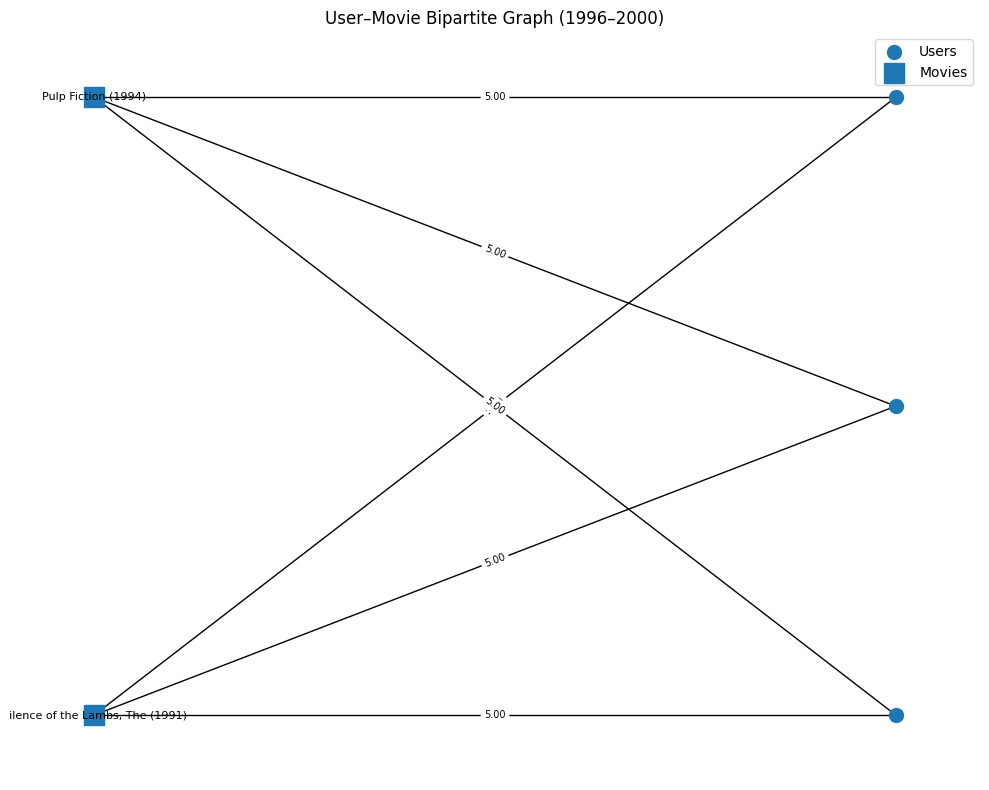

In [67]:
# Grafo 2000–2005
visualize_bipartite_graph(
    G_1996_2000,
    max_users=3,
    max_movies=2,
    title="User–Movie Bipartite Graph (1996–2000)",
    show_edge_labels=True,
    edge_label_decimals=2,
    max_edges_labeled=50
)

### shell

bc sometimes this visualization its cleaner

In [68]:


def visualize_bipartite_shell(
    G,
    max_users=30,
    max_movies=30,
    title=None,
    show_edge_labels=True,
    edge_label_decimals=2, 
    max_edges_labeled=30
):
    """
    Visualize the bipartite graph in a Shell (circular) layout
    using the classic (minimalist) style, with support for edge tags.

    - Inner circle: Movies
    - Outer circle: Users
    """

    # --- 1. Separate partitions (Robust Check 0/1 or strings) ---
    user_nodes = [n for n, d in G.nodes(data=True) if d.get("bipartite") in [0, "users"]]
    movie_nodes = [n for n, d in G.nodes(data=True) if d.get("bipartite") in [1, "movies"]]

    if not user_nodes or not movie_nodes:
        print("Error: Graph does not have valid 'bipartite' attributes.")
        return

    # --- 2. Limit nodes (Top Degree) ---
    user_nodes_sorted = sorted(user_nodes, key=lambda n: G.degree(n), reverse=True)
    movie_nodes_sorted = sorted(movie_nodes, key=lambda n: G.degree(n), reverse=True)

    # Correct slicing
    user_nodes_sub = user_nodes_sorted[:max_users]
    movie_nodes_sub = movie_nodes_sorted[:max_movies]

    # Create Subgraph
    nodes_to_keep = list(user_nodes_sub) + list(movie_nodes_sub)
    H = G.subgraph(nodes_to_keep).copy()

    # Define local lists for H
    users_H = [n for n in H.nodes if n in user_nodes]
    movies_H = [n for n in H.nodes if n in movie_nodes]

    # --- 3. Shell Layout ---
    # nlist defines concentric rings (Inner -> Outer)
    # movies_H inside, users_H outside
    pos = nx.shell_layout(H, nlist=[movies_H, users_H])

    # --- 4. Edge Styling (Classic width 0.2) ---
    edge_weights = [H[u][v].get("weight", 1.0) for u, v in H.edges()]
    edge_widths = [w * 0.2 for w in edge_weights]

    plt.figure(figsize=(10, 10)) # Square figure to avoid deforming the circle

    # --- 5. Draw Nodes (Classic Style) ---
    # Movies (Inner)
    nx.draw_networkx_nodes(
        H, pos, nodelist=movies_H, node_size=200, 
        node_shape="s", label="Movies"
        # No specific node_color -> uses default (usually blue/red depending on version)
    )

    # Users (Outer)
    nx.draw_networkx_nodes(
        H, pos, nodelist=users_H, node_size=100, 
        node_shape="o", label="Users"
    )

    # Draw Edges
    nx.draw_networkx_edges(H, pos, width=edge_widths)

    # --- 6. Node Labels (Titles) ---
    movie_labels = {}
    for n in movies_H:
        full_title = H.nodes[n].get("title", str(n))
        # Shorten very long titles for the circle layout
        short_title = full_title[:20] + "..." if len(full_title) > 20 else full_title
        movie_labels[n] = short_title

    nx.draw_networkx_labels(H, pos, labels=movie_labels, font_size=8)

    # --- 7. Edge Labels (Ratings + Tags) ---
    if show_edge_labels:
        edge_labels_dict = {}
        
        # Collect data
        edges_data = []
        for u, v, data in H.edges(data=True):
            w = data.get("weight", 0.0)
            t = data.get("tag", "")
            # Priority if it has a tag
            has_tag = 1 if (t and isinstance(t, str) and len(t) > 0) else 0
            edges_data.append((u, v, w, t, has_tag))

        # Sort: Tags first, then high rating
        edges_data.sort(key=lambda x: (x[4], x[2]), reverse=True)
        edges_to_draw = edges_data[:max_edges_labeled]

        # Build String
        for u, v, w, t, has_tag in edges_to_draw:
            label_str = f"{w:.{edge_label_decimals}f}"
            if has_tag:
                label_str += f"\n[{t}]"
            
            edge_labels_dict[(u, v)] = label_str

        # Draw labels (Clean style without white boxes)
        nx.draw_networkx_edge_labels(
            H,
            pos,
            edge_labels=edge_labels_dict,
            font_size=7
        )

    # --- 8. Final touches ---
    plt.axis("off")
    if title:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

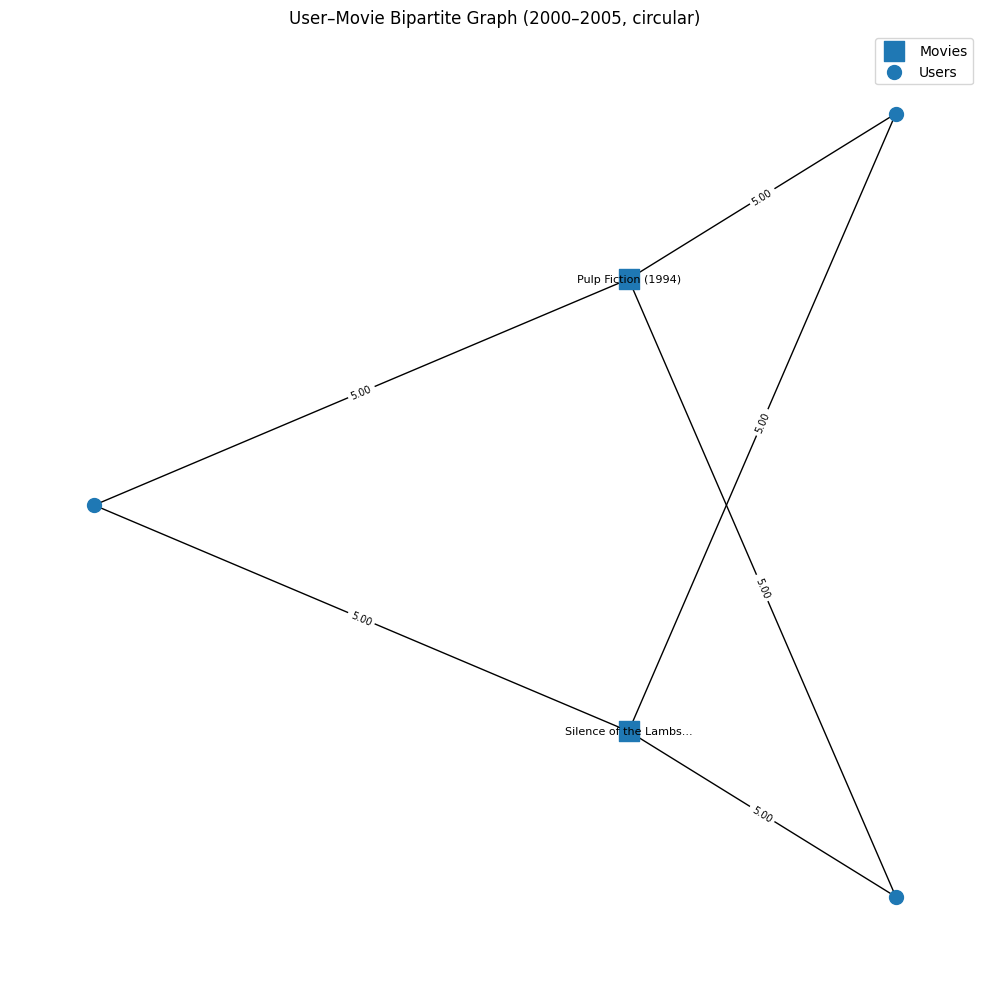

In [69]:
visualize_bipartite_shell(
    G_1996_2000,
    max_users=3,
    max_movies=2,
    title="User–Movie Bipartite Graph (2000–2005, circular)"
)

## Degree distributions & attention concentration

In [ ]:
def analyze_attention_concentration(G, period_name, bipartite_set=1):
    """
    Calculates attention concentration statistics for movie nodes.
    bipartite_set=1 assumes these are movies (based on your previous code).
    """
    # 1. Extract movie degrees
    # Filter nodes that are movies and obtain their degree
    movie_nodes = [n for n, d in G.nodes(data=True) if d.get("bipartite") == bipartite_set]
    degrees = [G.degree(n) for n in movie_nodes]
    
    # Sort from highest to lowest
    degrees.sort(reverse=True)
    total_ratings = sum(degrees)
    num_movies = len(degrees)
    
    if num_movies == 0:
        return None

    # 2. Calculate market share (Share of Attention)
    # Top 1%, 5%, 10%
    def get_share(percent):
        k = int(np.ceil(percent * 0.01 * num_movies))
        top_k_sum = sum(degrees[:k])
        return (top_k_sum / total_ratings) * 100

    share_1 = get_share(1)
    share_5 = get_share(5)
    share_10 = get_share(10)

    print(f"--- {period_name} ---")
    print(f"Total Movies: {num_movies}")
    print(f"Total Ratings: {total_ratings}")
    print(f"Top 1% movies capture:  {share_1:.2f}% of attention")
    print(f"Top 5% movies capture:  {share_5:.2f}% of attention")
    print(f"Top 10% movies capture: {share_10:.2f}% of attention")
    
    return degrees

In [ ]:
deg_96 = analyze_attention_concentration(G_1996_2000, "1996-2000")

Cálculo de Concentración de Atención:

--- 1996-2000 ---
Total Movies: 2813
Total Ratings: 3795756
Top 1% movies capture:  7.48% of attention
Top 5% movies capture:  25.58% of attention
Top 10% movies capture: 40.44% of attention


In [72]:
deg_18 = analyze_attention_concentration(G_2018_2022, "2018-2022")

--- 2018-2022 ---
Total Movies: 5840
Total Ratings: 5050062
Top 1% movies capture:  10.12% of attention
Top 5% movies capture:  34.03% of attention
Top 10% movies capture: 50.69% of attention


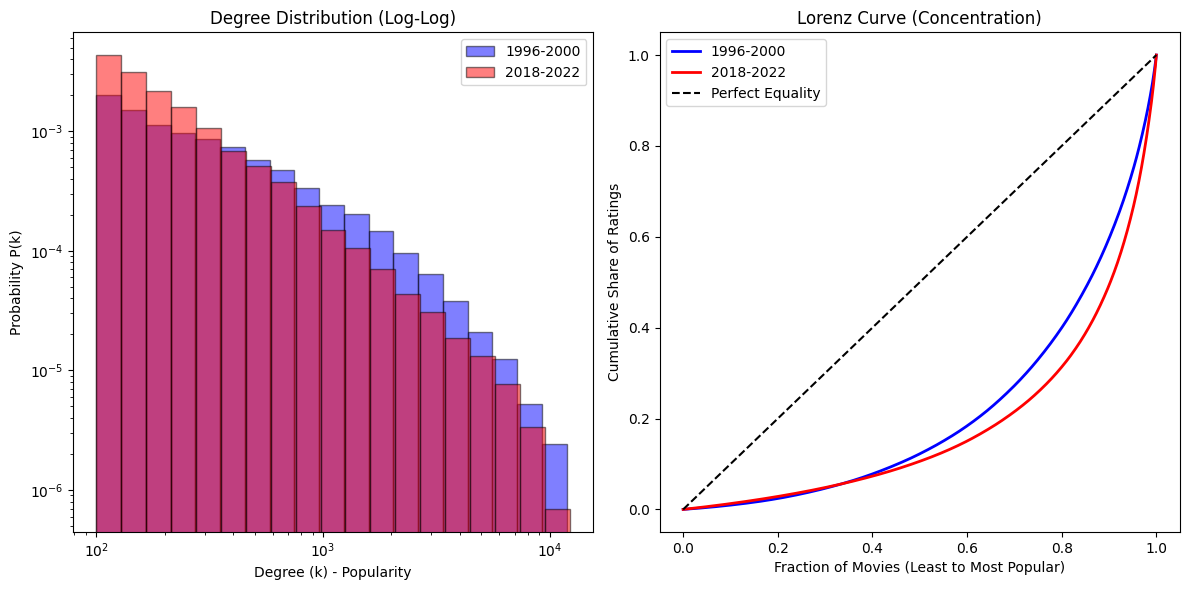

In [ ]:
# --- PLOTTING (Visual Comparison) ---
plt.figure(figsize=(12, 6))

# 1. Log-Log Degree Distribution (PDF)
plt.subplot(1, 2, 1)

def plot_loglog_hist(degrees, label, color):
    # Use logarithmic bins for clear visualization
    if not degrees: return
    bins = np.logspace(np.log10(min(degrees)), np.log10(max(degrees)), 20)
    plt.hist(degrees, bins=bins, density=True, alpha=0.5, label=label, color=color, edgecolor='black')

plot_loglog_hist(deg_96, "1996-2000", "blue")
plot_loglog_hist(deg_18, "2018-2022", "red")

plt.xscale('log')
plt.yscale('log')
plt.title("Degree Distribution (Log-Log)")
plt.xlabel("Degree (k) - Popularity")
plt.ylabel("Probability P(k)")
plt.legend()

# 2. Lorenz Curve (Visual Concentration)
plt.subplot(1, 2, 2)

def plot_lorenz(degrees, label, color):
    if not degrees: return
    # Sort ascending for Lorenz
    sorted_deg = np.sort(degrees)
    # Cumulative sum
    cum_deg = np.cumsum(sorted_deg) / np.sum(sorted_deg)
    # X Axis: Fraction of movies
    x_axis = np.linspace(0, 1, len(cum_deg))
    plt.plot(x_axis, cum_deg, label=label, color=color, linewidth=2)

plot_lorenz(deg_96, "1996-2000", "blue")
plot_lorenz(deg_18, "2018-2022", "red")
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Equality") # Line of equality

plt.title("Lorenz Curve (Concentration)")
plt.xlabel("Fraction of Movies (Least to Most Popular)")
plt.ylabel("Cumulative Share of Ratings")
plt.legend()

plt.tight_layout()
plt.show()

## Betweenness and “bridge movies/users”

In [ ]:
def analyze_bridges(G, period_name, top_n=10):
    print(f"\nCalculating Betweenness Centrality for {period_name}...")
    print("(This may take a while depending on the graph size...)")
    
    # 1. Calculate Betweenness
    # k=None calculates exact. If it takes >5 min, use k=1000 to approximate.
    # weight='weight' uses rating as distance (note: high rating = short distance?)
    # Generally in betweenness we use 'weight' as cost. 
    # For movies, sometimes it is better not to use weights or invert the rating (1/rating).
    # To simplify and see pure structure, we will do it WITHOUT weights first.
    bc = nx.betweenness_centrality(G, k=500, normalized=True)
    
    # 2. Filter only Movie nodes and get attributes
    bridges = []
    movie_nodes = [n for n, d in G.nodes(data=True) if d.get("bipartite") == 1]
    
    for m_node in movie_nodes:
        score = bc.get(m_node, 0)
        # Retrieve metadata stored in the graph
        title = G.nodes[m_node].get("title", "Unknown")
        genres = G.nodes[m_node].get("genres", "Unknown")
        degree = G.degree(m_node)
        
        bridges.append({
            "node": m_node,
            "title": title,
            "genres": genres,
            "betweenness": score,
            "degree": degree
        })
        
    # 3. Create DataFrame and Sort
    df_bridges = pd.DataFrame(bridges)
    df_bridges = df_bridges.sort_values("betweenness", ascending=False)
    
    print(f"--- Top {top_n} Bridge Movies ({period_name}) ---")
    print(df_bridges[["title", "genres", "betweenness", "degree"]].head(top_n))
    
    return df_bridges

In [ ]:
bridges_96 = analyze_bridges(G_1996_2000, "1996-2000")



Calculando Betweenness Centrality para 1996-2000...
(Esto puede tardar un poco dependiendo del tamaño del grafo...)
--- Top 10 Bridge Movies (1996-2000) ---
                                         title  \
296           Silence of the Lambs, The (1991)   
16                         Pulp Fiction (1994)   
294          Terminator 2: Judgment Day (1991)   
25                        Jurassic Park (1993)   
236                        Forrest Gump (1994)   
261                       Fugitive, The (1993)   
14   Star Wars: Episode IV - A New Hope (1977)   
28                     Schindler's List (1993)   
226           Shawshank Redemption, The (1994)   
424                               Fargo (1996)   

                               genres  betweenness  degree  
296             Crime|Horror|Thriller     0.013629   11866  
16        Comedy|Crime|Drama|Thriller     0.013113   11649  
294                     Action|Sci-Fi     0.012127   11356  
25   Action|Adventure|Sci-Fi|Thriller     0.011

In [82]:
bridges_96

node                                             title  \
296    m_593                  Silence of the Lambs, The (1991)   
16     m_296                               Pulp Fiction (1994)   
294    m_589                 Terminator 2: Judgment Day (1991)   
25     m_480                              Jurassic Park (1993)   
236    m_356                               Forrest Gump (1994)   
...      ...                                               ...   
1890  m_2074  Night Porter, The (Portiere di notte, Il) (1974)   
2166  m_3767         Missing in Action 2: The Beginning (1985)   
2784  m_3577                          Two Moon Junction (1988)   
2670  m_3031                                Repossessed (1990)   
2167  m_3768            Braddock: Missing in Action III (1988)   

                                genres   betweenness  degree  
296              Crime|Horror|Thriller  1.362945e-02   11866  
16         Comedy|Crime|Drama|Thriller  1.311324e-02   11649  
294                      Action|Sci-Fi  1.212693e-02   11356  
25    Action|Adventure|Sci-Fi|Thriller  1.185074e-02   11585  
236           Comedy|Drama|Romance|War  1.179951e-02   11528  
...                                ...           ...     ...  
1890               Crime|Drama|Romance  2.242972e-07     109  
2166                        Action|War  2.230323e-07     138  
2784                     Drama|Romance  2.134545e-07     100  
2670                            Comedy  2.042437e-07     100  
2167                        Action|War  1.234150e-07     101  

[2813 rows x 5 columns]

In [77]:
bridges_18 = analyze_bridges(G_2018_2022, "2018-2022")


Calculando Betweenness Centrality para 2018-2022...
(Esto puede tardar un poco dependiendo del tamaño del grafo...)
--- Top 10 Bridge Movies (2018-2022) ---
                                                 title  \
193                                   Inception (2010)   
151                            Dark Knight, The (2008)   
359                                 Matrix, The (1999)   
37                                   Fight Club (1999)   
8                     Shawshank Redemption, The (1994)   
388  Lord of the Rings: The Fellowship of the Ring,...   
252                                Interstellar (2014)   
90   Lord of the Rings: The Return of the King, The...   
76       Lord of the Rings: The Two Towers, The (2002)   
7                                  Pulp Fiction (1994)   

                                              genres  betweenness  degree  
193  Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX     0.008774   12241  
151                          Action|Crime|Drama|IMA

In [83]:
bridges_18

node                                     title  \
193    m_79132                          Inception (2010)   
151    m_58559                   Dark Knight, The (2008)   
359     m_2571                        Matrix, The (1999)   
37      m_2959                         Fight Club (1999)   
8        m_318          Shawshank Redemption, The (1994)   
...        ...                                       ...   
5199    m_6776  Lagaan: Once Upon a Time in India (2001)   
1763  m_207638                    La belle époque (2019)   
3592   m_80398            22 Bullets (L'immortel) (2010)   
3737    m_3946                         Get Carter (2000)   
3728    m_2861               For Love of the Game (1999)   

                                               genres   betweenness  degree  
193   Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX  8.773754e-03   12241  
151                           Action|Crime|Drama|IMAX  7.740991e-03   11461  
359                            Action|Sci-Fi|Thriller  7.591225e-03   11452  
37                        Action|Crime|Drama|Thriller  7.061711e-03   10770  
8                                         Crime|Drama  6.842540e-03   10595  
...                                               ...           ...     ...  
5199                     Comedy|Drama|Musical|Romance  3.142614e-07     103  
1763                                     Comedy|Drama  2.936062e-07     100  
3592                            Action|Crime|Thriller  2.792062e-07     101  
3737                            Action|Drama|Thriller  2.682699e-07     106  
3728                                     Comedy|Drama  2.557694e-07     101  

[5840 rows x 5 columns]

In [84]:
bridges_96.to_csv("../data/processed/top_bridges_1996_2000.csv", index=False)
bridges_18.to_csv("../data/processed/top_bridges_2018_2022.csv", index=False)

# NLP

In [33]:
# Precomputed bipartite edge lists (for consistency with graph analyses)
edges_early = edge_list_1996_2000

edges_late = edge_list_2018_2022

# Convert timestamps to datetime
ratings["datetime"] = pd.to_datetime(ratings["timestamp"], unit="s")
tags["datetime"] = pd.to_datetime(tags["timestamp"], unit="s")
ratings["year"] = ratings["datetime"].dt.year
tags["year"] = tags["datetime"].dt.year

In [34]:
def filter_period(df, start, end, year_col="year"):
    return df[(df[year_col] >= start) & (df[year_col] <= end)].copy()


ratings_early = filter_period(ratings, 1996, 2000)
ratings_late = filter_period(ratings, 2018, 2022)
tags_early = filter_period(tags, 1996, 2000)
tags_late = filter_period(tags, 2018, 2022)
print(f"Early period ratings: {len(ratings_early):,}")
print(f"Late period ratings: {len(ratings_late):,}")
print(f"Early period tags: {len(tags_early):,}")
print(f"Late period tags: {len(tags_late):,}")

Early period ratings: 6,087,170
Late period ratings: 6,919,815
Early period tags: 0
Late period tags: 1,502,239


### Motivation for Updating Time Periods
User-generated tags in MovieLens were only introduced around 2005–2006. Therefore, the original early-period window (1996–2000) contains **zero tags**, making it impossible to conduct tag-based NLP analysis.

To ensure a fair, text-rich comparison across periods, we replace:
**Early period (old):** 1996–2000 → **New early period:** 2006–2010
**Late period:** remains **2018–2022**

This adjustment preserves the theoretical goal — testing whether audience attention structure changed over time — while ensuring that **both periods contain user-generated tags**, making genre–tag NLP analysis meaningful and comparable.

## Bulding 2006-2010 Network

In [35]:
df_2006_2010_filtered = get_cleaned_period_data(
    ratings, 
    start_year=2006, 
    end_year=2010, 
    min_user_ratings=100, 
    min_movie_ratings=100
)

df_2006_2010_filtered = df_2006_2010_filtered.drop(columns=['timestamp', 'datetime'])
edge_list_2006_2010 = build_edge_list_strategy_A(
    ratings_filtered=df_2006_2010_filtered,
    movies_df=movies,
    tags_user_df=tags_processed,
    edge_csv_name="edges_2006_2010.csv"
)

print(f"Total edges: {len(edge_list_2006_2010):,}")
print(f"Edges with tags: {len(edge_list_2006_2010[edge_list_2006_2010['tag'] != '']):,}")



🔄 PROCESSING PERIOD: 2006 - 2010
📅 1. Temporal Filter (2006-2010):
   -> Ratings found:     5,447,354
   -> Unique users:      56,178
   -> Unique movies:     14,683

🧹 2. K-Core Cleaning (Min User: 100, Min Movie: 100)...
   > Iteration 1: reducing to 4,084,513 ratings...
   > Iteration 2: reducing to 4,032,652 ratings...
   > Iteration 3: reducing to 4,025,866 ratings...
   > Iteration 4: reducing to 4,025,371 ratings...
   > Iteration 5: reducing to 4,025,272 ratings...
   > Iteration 6: reducing to 4,025,173 ratings...
✅ FINISHED after 7 iterations.
   -> Final ratings:   4,025,173 (Retention: 73.89%)
   -> Core users:      14,476
   -> Core movies:     4,618

Edge list saved to: edges_2006_2010.csv
Total edges: 4,025,173
Edges with tags: 47,222


In [36]:
G_2006_2010 = build_bipartite_graph_from_edge_list(edge_list_2006_2010)
describe_bipartite(edge_list_2006_2010, G_2006_2010, name="2006–2010 network")

Building NetworkX graph...
Graph built: 19094 nodes, 4025173 edges.
===== 2006–2010 network =====
Edges (ratings): 4,025,173
User nodes:      14,476
Movie nodes:     4,618

User degree stats (number of movies rated per user):
  min:   100
  max:   3995
  mean:  278.06
  median:204.00
  p90:   526.00

Movie degree stats (number of users per movie):
  min:   100
  max:   10924
  mean:  871.63
  median:339.00
  p90:   2195.80

Attention concentration:
  Top 10% movies receive 49.34% of all ratings



In [38]:
ratings = pd.read_csv("../data/ml-latest/ratings.csv")
movies = pd.read_csv("../data/ml-latest/movies.csv")
tags = pd.read_csv("../data/ml-latest/tags.csv")


# Precomputed bipartite edge lists (for consistency with graph analyses)
edges_early = edge_list_2006_2010
edges_late = edge_list_2018_2022


# Convert timestamps to datetime (if not already done)
ratings["datetime"] = pd.to_datetime(ratings["timestamp"], unit="s")
tags["datetime"] = pd.to_datetime(tags["timestamp"], unit="s")
ratings["year"] = ratings["datetime"].dt.year
tags["year"] = tags["datetime"].dt.year

In [39]:
# 2. Filter data into periods
def filter_period(df, start, end, year_col="year"):
    return df[(df[year_col] >= start) & (df[year_col] <= end)].copy()


ratings_early = filter_period(ratings, 2006, 2010)
ratings_late = filter_period(ratings, 2018, 2022)
tags_early = filter_period(tags, 2006, 2010)
tags_late = filter_period(tags, 2018, 2022)


print(f"Early period ratings: {len(ratings_early):,}")
print(f"Late period ratings: {len(ratings_late):,}")
print(f"Early period tags: {len(tags_early):,}")
print(f"Late period tags: {len(tags_late):,}")

Early period ratings: 5,447,354
Late period ratings: 6,919,815
Early period tags: 211,996
Late period tags: 1,502,239


The later period has more ratings overall, so the user–movie network is denser in the late period. This already hints that audience attention may be more spread out, but we need the genre analysis to say anything precise.

User-generated tags massively increase over time. The late period has ~7× more tags, giving us a much richer text signal about how users describe movies.



In [40]:
# 3. Parse genres and aggregate tags per movie. 
# Each movie is represented by its title, genres, and concatenated user tags from the corresponding period.
# Parse genres into lists
movies["genres_list"] = movies["genres"].fillna("").apply(lambda g: g.split('|') if isinstance(g, str) else [])


# Function to aggregate tags by movie within a period
def aggregate_tags(tags_df):
    tags_clean = (
    tags_df.dropna(subset=["tag"])
    .assign(tag=lambda x: x["tag"].str.lower().str.replace(r"[^a-z0-9\s]", "", regex=True))
    )
    return tags_clean.groupby("movieId")["tag"].apply(lambda x: " ".join(x)).reset_index()


tags_agg_early = aggregate_tags(tags_early)
tags_agg_late = aggregate_tags(tags_late)

In [41]:
def build_movie_text_table(ratings_period, tags_agg_period, label):
    # Select movies that appear in this period's ratings
    movie_ids = ratings_period["movieId"].unique()
    df = movies[movies["movieId"].isin(movie_ids)].copy()
    df = df.merge(tags_agg_period, on="movieId", how="left")

    # Create unified text field
    df["tags"] = df["tag"].fillna("")
    df["genres_text"] = df["genres_list"].apply(lambda x: " ".join([g.lower() for g in x]))
    df["text_raw"] = df["title"] + " " + df["genres_text"] + " " + df["tags"]

    # Basic stats
    df["n_tags"] = df["tags"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
    print(f"\n[{label}] Movies with tags: {df['n_tags'].gt(0).sum():,} / {len(df):,}")
    print(f"[{label}] Avg. tags per movie: {df['n_tags'].mean():.2f}")
    return df[["movieId", "title", "genres_list", "n_tags", "text_raw"]]

movies_early_text = build_movie_text_table(ratings_early, tags_agg_early, "Early (2006–2010)")
movies_late_text = build_movie_text_table(ratings_late, tags_agg_late, "Late (2018–2022)")


[Early (2006–2010)] Movies with tags: 10,260 / 14,683
[Early (2006–2010)] Avg. tags per movie: 24.99

[Late (2018–2022)] Movies with tags: 43,306 / 74,543
[Late (2018–2022)] Avg. tags per movie: 33.26


In the late period, a larger catalog is present (many more movies overall), and a substantial subset has tags. For the movies that do have tags, the late period shows more tags per movie on average → richer descriptions per title. Even though the fraction of tagged movies is slightly lower in the late period, the absolute number of tagged movies and the density of tags per movie are both much higher. This is good for NLP: more information to estimate genres/themes and diversity.


### NLP preprocessing: tokenization, cleaning, lexical diversity
We now process the movie-level text (`text_raw`) constructed.
The goal is to obtain clean token lists and a simple measure of lexical diversity for each period.

In [42]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk import bigrams
import re

In [43]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


TOKEN_RE = re.compile(r"[A-Za-z][A-Za-z0-9']+")




def tokenize_and_clean(text):
    """Tokenize and clean a text string into a list of normalized tokens."""
    if not isinstance(text, str):
        return []
    tokens = TOKEN_RE.findall(text.lower())
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens




# Apply to both periods
movies_early_text["tokens"] = movies_early_text["text_raw"].apply(tokenize_and_clean)
movies_late_text["tokens"] = movies_late_text["text_raw"].apply(tokenize_and_clean)


# Corpus-level lexical diversity per period
all_tokens_early = [tok for toks in movies_early_text["tokens"] for tok in toks]
all_tokens_late = [tok for toks in movies_late_text["tokens"] for tok in toks]


vocab_early = set(all_tokens_early)
vocab_late = set(all_tokens_late)


lex_div_early = len(vocab_early) / max(1, len(all_tokens_early))
lex_div_late = len(vocab_late) / max(1, len(all_tokens_late))


print("Lexical diversity (type/token ratio):")
print(f"Early (2006–2010): types={len(vocab_early):,}, tokens={len(all_tokens_early):,}, TTR={lex_div_early:.4f}")
print(f"Late (2018–2022): types={len(vocab_late):,}, tokens={len(all_tokens_late):,}, TTR={lex_div_late:.4f}")

Lexical diversity (type/token ratio):
Early (2006–2010): types=23,446, tokens=392,936, TTR=0.0597
Late (2018–2022): types=59,383, tokens=2,580,848, TTR=0.0230


In [51]:
# Add per-movie token counts for later analyses
movies_early_text["n_tokens"] = movies_early_text["tokens"].apply(len)
movies_late_text["n_tokens"] = movies_late_text["tokens"].apply(len)


print("Per-movie token statistics (early):")
print(movies_early_text["n_tokens"].describe())


print("Per-movie token statistics (late):")
print(movies_late_text["n_tokens"].describe())

Per-movie token statistics (early):
count    14683.000000
mean        26.761289
std         61.759290
min          1.000000
25%          5.000000
50%          9.000000
75%         22.000000
max       1672.000000
Name: n_tokens, dtype: float64
Per-movie token statistics (late):
count    74543.000000
mean        34.622272
std        152.623309
min          1.000000
25%          4.000000
50%          7.000000
75%         14.000000
max       6470.000000
Name: n_tokens, dtype: float64


#### Lexical diversity (TTR)

The late period has many more tokens and a much larger vocabulary (≈ 59k types vs 23k).

The type/token ratio is lower in the late period (0.0230 vs 0.0597).

This is expected:

- As a corpus gets larger, TTR typically drops (you see more repetition relative to the growing token count).
- The fact that the late period has more tags and more movies means more reused genre/descriptor vocabulary (e.g. “drama”, “action”, “series”, franchise names), which pushes TTR down, even though the absolute vocabulary size is higher.

So: the language around movies in 2018–2022 is richer in absolute terms (many more distinct words) but also more repetitive due to a much larger corpus and strong reuse of popular descriptors.

## Descriptive vocabulary comparison (unigrams and bigrams)
In this section, we summarize and compare the vocabulary used to describe movies in the two periods.
We focus on:

- **Unigram frequencies**: the most common tokens in early vs. late text.
- **Bigram frequencies**: frequent two-word combinations that capture multi-word genres or themes (e.g. "science fiction", "romantic comedy").

In [54]:
# Helper: plot top-N words for a given FreqDist
def plot_top_words(fd, title, n=20):
    most_common = fd.most_common(n)
    words = [w for w, _ in most_common]
    freqs = [f for _, f in most_common]
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(words)), freqs)
    plt.xticks(range(len(words)), words, rotation=45, ha="right")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [53]:
# Unigram frequency distributions

# Build corpus-level frequency distributions
fd_early = FreqDist(all_tokens_early)
fd_late = FreqDist(all_tokens_late)

print("Top 20 tokens (early 2006–2010):")
print(fd_early.most_common(20))

print("\nTop 20 tokens (late 2018–2022):")
print(fd_late.most_common(20))

Top 20 tokens (early 2006–2010):
[('drama', 8661), ('comedy', 8126), ('romance', 3617), ('action', 3526), ('based', 2934), ('thriller', 2846), ('war', 2833), ('best', 2751), ('book', 2632), ('movie', 2627), ('crime', 2544), ('nudity', 2428), ('oscar', 2319), ('dvd', 2034), ('adventure', 2028), ('horror', 1924), ('fantasy', 1855), ('film', 1730), ('classic', 1685), ('scifi', 1667)]

Top 20 tokens (late 2018–2022):
[('comedy', 37940), ('drama', 33917), ('relationship', 16629), ('action', 16361), ('thriller', 15867), ('horror', 14960), ('romance', 13870), ('film', 13731), ('female', 13110), ('woman', 12874), ('based', 12802), ('reference', 11543), ('character', 11379), ('war', 10950), ('crime', 10908), ('dark', 10551), ('ending', 10351), ('man', 10125), ('great', 10011), ('child', 9998)]


Early (2006–2010) top tokens:
This looks like an environment where tags are often:
- Genre labels,
- Award markers (oscar, best),
- Media-format / collection markers (dvd),
- A bit of content filtering (nudity).

Late (2018–2022) top tokens:
This suggests that in the late period, tags are less about “is it a drama/DVD/Oscar movie?” and more about:

- Relationships and characters,
- Mood and tone (dark, ending),
- Gender and representation (female, woman),

which feels like richer, more interpretive annotation.

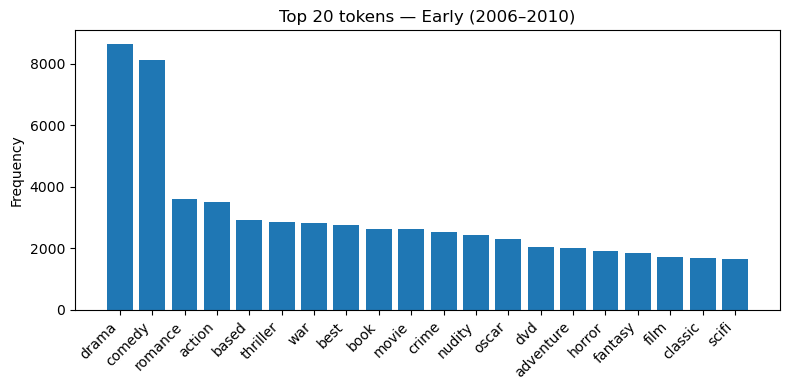

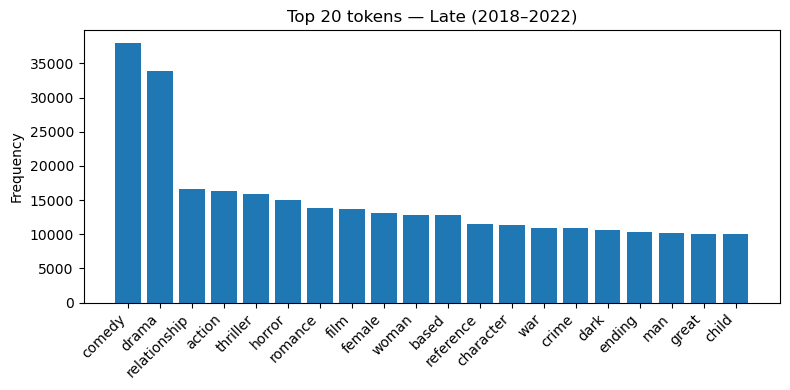

In [55]:
# Visualize
plot_top_words(fd_early, "Top 20 tokens — Early (2006–2010)")
plot_top_words(fd_late, "Top 20 tokens — Late (2018–2022)")

In [56]:
# Bigram frequency distributions
# We now look at the most frequent bigrams in each period.
# Construct bigrams from token lists
bigrams_early = [bg for toks in movies_early_text["tokens"] for bg in bigrams(toks)]
bigrams_late = [bg for toks in movies_late_text["tokens"] for bg in bigrams(toks)]

fd_bigram_early = FreqDist(bigrams_early)
fd_bigram_late = FreqDist(bigrams_late)

print("Top 20 bigrams (early 2006–2010):")
print(fd_bigram_early.most_common(20))

print("\nTop 20 bigrams (late 2018–2022):")
print(fd_bigram_late.most_common(20))

Top 20 bigrams (early 2006–2010):
[(('oscar', 'best'), 1920), (('based', 'book'), 1761), (('nudity', 'topless'), 1477), (('comedy', 'drama'), 1446), (('drama', 'romance'), 1423), (('crime', 'drama'), 1083), (('true', 'story'), 1014), (('twist', 'ending'), 870), (('imdb', 'top'), 765), (('world', 'war'), 743), (('dark', 'comedy'), 737), (('time', 'travel'), 736), (('action', 'adventure'), 728), (('drama', 'thriller'), 681), (('less', 'rating'), 674), (('tumeys', 'dvd'), 643), (('comedy', 'romance'), 603), (('erlends', 'dvd'), 588), (('full', 'frontal'), 588), (('comic', 'book'), 585)]

Top 20 bigrams (late 2018–2022):
[(('genre', 'listed'), 5343), (('true', 'story'), 5214), (('comedy', 'drama'), 5159), (('visually', 'appealing'), 5012), (('drama', 'romance'), 4700), (('dark', 'comedy'), 4132), (('twist', 'ending'), 3914), (('new', 'york'), 3711), (('social', 'commentary'), 3572), (('crime', 'drama'), 3464), (('woman', 'director'), 3399), (('coming', 'age'), 3378), (('based', 'true'), 33

Early bigrams:

Early tags mix genres, awards, and quite a lot of collector/platform/explicit-content tagging.

Late bigrams:

Compared to early, late bigrams point more towards:
- Aesthetic and social interpretation (visually appealing, social commentary)
- Authorship and identity (woman director)
- Art-house / niche labels (independent film, cult film)

This fits your hypothesis-testing narrative: the language of description has clearly shifted, even if per-user genre entropy stayed fairly stable.

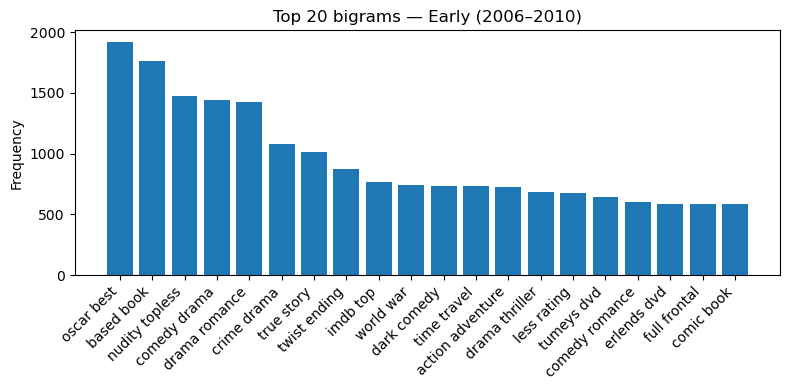

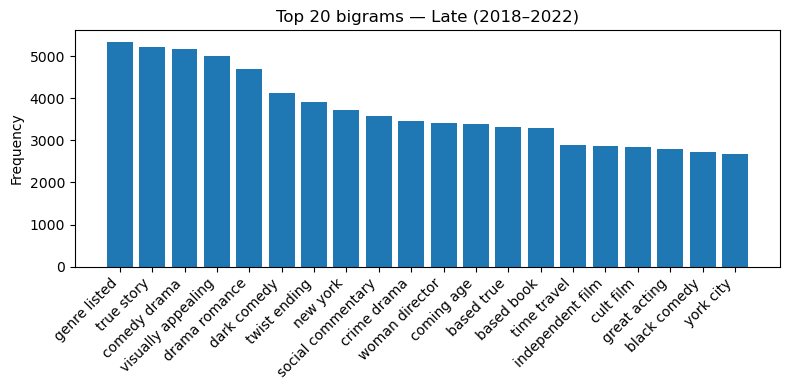

In [57]:
# Simple barplot helper for bigrams
def plot_top_bigrams(fd, title, n=20):
    most_common = fd.most_common(n)
    labels = [" ".join(bg) for bg, _ in most_common]
    freqs = [f for _, f in most_common]
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(labels)), freqs)
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_top_bigrams(fd_bigram_early, "Top 20 bigrams — Early (2006–2010)")
plot_top_bigrams(fd_bigram_late, "Top 20 bigrams — Late (2018–2022)")

## TF-IDF and period-characteristic vocabulary
Here we use TF-IDF to identify terms that are important within each period's movie descriptions, and then compute a simple "keyness" measure that highlights words that are relatively more typical of the early vs. late period.

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Build text_clean from tokens for use with scikit-learn
movies_early_text["text_clean"] = movies_early_text["tokens"].apply(lambda toks: " ".join(toks))
movies_late_text["text_clean"] = movies_late_text["tokens"].apply(lambda toks: " ".join(toks))

# %% [markdown]
#TF-IDF per period (movie-level documents)
def compute_tfidf_top_terms(text_series, label, max_features=20000, top_n=30):
    """
    Fit a TF-IDF vectorizer on the given text series and print top-N terms
    by average TF-IDF score across documents.
    """
    vectorizer = TfidfVectorizer(
        lowercase=False,        # we already lowercased
        token_pattern=r"\S+",   # tokens are space-separated
        max_features=max_features
    )
    X = vectorizer.fit_transform(text_series)
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Mean TF-IDF per term
    mean_tfidf = np.asarray(X.mean(axis=0)).ravel()
    top_idx = mean_tfidf.argsort()[::-1][:top_n]

    print(f"\nTop {top_n} TF-IDF terms — {label}:")
    for term, score in zip(feature_names[top_idx], mean_tfidf[top_idx]):
        print(f"{term:20s} {score:.4f}")

    return vectorizer, X, feature_names, mean_tfidf

vec_early, X_early, feats_early, mean_tfidf_early = compute_tfidf_top_terms(
    movies_early_text["text_clean"], "Early (2006–2010)"
)

vec_late, X_late, feats_late, mean_tfidf_late = compute_tfidf_top_terms(
    movies_late_text["text_clean"], "Late (2018–2022)"
)


Top 30 TF-IDF terms — Early (2006–2010):
drama                0.0517
comedy               0.0427
romance              0.0276
thriller             0.0226
crime                0.0198
horror               0.0188
action               0.0186
war                  0.0162
documentary          0.0140
adventure            0.0138
nudity               0.0119
betamax              0.0113
mystery              0.0109
musical              0.0109
based                0.0104
rating               0.0099
movie                0.0098
child                0.0095
fantasy              0.0095
sci                  0.0095
less                 0.0093
western              0.0092
book                 0.0089
film                 0.0089
topless              0.0085
best                 0.0082
dvd                  0.0073
oscar                0.0069
story                0.0065
animation            0.0065

Top 30 TF-IDF terms — Late (2018–2022):
drama                0.0618
comedy               0.0534
documentary          

**Early (2006–2010) TF-IDF top terms (subset):**
Early tags are heavily anchored in:

- Standard genre labels.
- Physical/technical media (betamax, dvd), and award/collection metadata (oscar, best, rating).
- Some explicit content markers (nudity, topless).

This matches the early MovieLens era: DVD ripping formats, collections, physical media, and Oscars are central “axes” of how people annotate movies.

**Late (2018–2022) TF-IDF top terms (subset):**
Late tags keep genre labels but shift focus towards:

- Relational/emotional content (love, relationship).
- Identity/representation (woman, director).
- Crime/violence specifics (murder, child, man often in contexts like “man kills”, “child protagonist”).
- Documentary is more salient in TF-IDF too, suggesting a more distinct documentary “tag space” in the later catalog.

Overall: TF-IDF shows an evolution from “Is this a drama/comedy DVD/Oscar movie?” towards “What is this about? Who made it? What relationships, identities, and violence does it depict?”.

#### Period-characteristic vocabulary via log-ratio
Using the raw frequency distributions from Section 5, we compute a simple log-ratio score for each token:
 
 $ {log2( p_early(token) / p_late(token) )}$

with add-k smoothing. Positive scores indicate tokens that are relatively more typical of the early period, negative scores tokens more typical of the late period.


In [59]:
from math import log2
# Raw counts and totals from Section 5
# (fd_early, fd_late, all_tokens_early, all_tokens_late already defined)
total_early = len(all_tokens_early)
total_late = len(all_tokens_late)

# Add-k smoothing parameter
k = 1.0

# Union vocabulary
vocab_union = set(fd_early.keys()) | set(fd_late.keys())
V = len(vocab_union)

log_ratio_scores = {}

for term in vocab_union:
    c_e = fd_early[term]
    c_l = fd_late[term]
    p_e = (c_e + k) / (total_early + k * V)
    p_l = (c_l + k) / (total_late + k * V)
    log_ratio_scores[term] = log2(p_e / p_l)

# Sort by score
sorted_terms = sorted(log_ratio_scores.items(), key=lambda x: x[1], reverse=True)

top_early_specific = sorted_terms[:30]
top_late_specific = sorted_terms[-30:]

print("\nTop 30 early-specific tokens (highest log-ratio early/late):")
for term, score in top_early_specific:
    print(f"{term:20s} {score: .3f}  (early count={fd_early[term]}, late count={fd_late[term]})")

print("\nTop 30 late-specific tokens (lowest log-ratio early/late):")
for term, score in top_late_specific:
    print(f"{term:20s} {score: .3f}  (early count={fd_early[term]}, late count={fd_late[term]})")


Top 30 early-specific tokens (highest log-ratio early/late):
perrot                10.495  (early count=248, late count=0)
dvdram                10.113  (early count=381, late count=1)
dvdr                  9.569  (early count=261, late count=1)
erlends               9.162  (early count=592, late count=5)
betamax               9.122  (early count=960, late count=9)
redbox                9.090  (early count=93, late count=0)
svens                 9.027  (early count=89, late count=0)
dvdvideo              8.885  (early count=570, late count=6)
erics                 8.884  (early count=162, late count=1)
bibliothek            8.740  (early count=294, late count=3)
bgab                  8.535  (early count=127, late count=1)
fewer                 8.535  (early count=63, late count=0)
lrc                   8.524  (early count=126, late count=1)
clearplay             8.413  (early count=293, late count=4)
dvr                   8.381  (early count=114, late count=1)
futuristmoviescom     8.

**Early-specific tokens (highest log-ratio):**
These look like user-specific shelving codes, library identifiers, nicknames, or local-language notes (Finnish, German etc.), plus format tags for physical/ripped media.

So early tagging is strongly shaped by how and where the user obtained/stored the movie, not just what it’s “about”.

**Late-specific tokens (lowest log-ratio):**
Late-period tags are more like fine-grained content annotations, close to parental-guidance / CW style:

- Exactly what kind of violence, what kind of nudity, which identity groups, which stylistic niche (psychotronic, A24).
- They also capture modern franchise and indie culture (mcu, a24), which did not exist in the early period.

### Connection to the null hypothesis (H₀)

H₀ claims that structure of audience attention is stable over time. Even if our user-level genre entropy looked quite similar between periods, the NLP evidence shows:

The descriptive dimensions used to annotate movies changed a lot:
from format/collection-oriented (DVD, Betamax, Redbox, user codes) to content/identity/violence/franchise-oriented (A24, MCU, LGBTQ, detailed triggers).

This suggests that what users pay attention to and find worth tagging is different, even if their high-level genre mix is similar.

Later, when you look at community-level text profiles, you can show that late communities are structured along these newer attention axes, which is strong content-based evidence against the idea that “nothing has changed”.

### Semantic movie networks based on TF-IDF similarity
Here we build a simple content-based movie–movie network for each period.
Nodes are movies; edges connect movies with high cosine similarity in TF-IDF space.

In [60]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

In [61]:
# Parameters for neighbor search
k_neighbors = 11         # 10 neighbors + self
min_similarity = 0.2     # threshold for keeping an edge

def build_content_edges(X, movie_ids, k=k_neighbors, min_sim=min_similarity, label=""):
    """
    Build a content-similarity edge list using k-nearest neighbors in TF-IDF space.

    Parameters
    ----------
    X : scipy.sparse matrix
        TF-IDF matrix (n_movies x n_terms)
    movie_ids : array-like
        MovieIds aligned with rows of X.
    k : int
        Number of nearest neighbors (including self).
    min_sim : float
        Minimum cosine similarity to keep an edge.
    label : str
        Label for printing summary information.

    Returns
    -------
    edges_df : pd.DataFrame
        DataFrame with columns [movieId_i, movieId_j, sim].
    """
    nn = NearestNeighbors(metric="cosine", algorithm="brute")
    nn.fit(X)
    distances, indices = nn.kneighbors(X, n_neighbors=k)

    rows = []
    n_movies = X.shape[0]
    for i in range(n_movies):
        mi = movie_ids[i]
        for dist, j in zip(distances[i], indices[i]):
            if i == j:
                continue  # skip self
            sim = 1.0 - dist
            if sim < min_sim:
                continue
            mj = movie_ids[j]
            rows.append((mi, mj, sim))

    edges_df = pd.DataFrame(rows, columns=["movieId_i", "movieId_j", "sim"])
    print(f"\n[{label}] Content edges: {len(edges_df):,} (min_sim={min_sim})")
    print(f"[{label}] Example edges:")
    print(edges_df.head())
    return edges_df

# Build edge lists for both periods
movie_ids_early = movies_early_text["movieId"].values
movie_ids_late = movies_late_text["movieId"].values

content_edges_early = build_content_edges(X_early, movie_ids_early, label="Early (2006–2010)")
content_edges_late = build_content_edges(X_late, movie_ids_late, label="Late (2018–2022)")


[Early (2006–2010)] Content edges: 135,345 (min_sim=0.2)
[Early (2006–2010)] Example edges:
   movieId_i  movieId_j       sim
0          1       3114  0.946795
1          1       2355  0.869672
2          1       6377  0.864664
3          1       4886  0.853147
4          1      50872  0.790564

[Late (2018–2022)] Content edges: 744,664 (min_sim=0.2)
[Late (2018–2022)] Example edges:
   movieId_i  movieId_j       sim
0          1       3114  0.739854
1          1     201588  0.639887
2          1       2355  0.603839
3          1      78499  0.597317
4          1     157296  0.545440


Both semantic spaces are locally dense: for each movie, there are plenty of reasonably similar neighbors in tag/genre space.

The late period naturally has far more content edges because it has far more movies; the construction is roughly comparable (same k, same threshold).


## Semantic communities
The previous community detection using greedy_modularity_communities can be slow on large graphs (e.g., the late 2018–2022 semantic network).
Here we switch to a faster algorithm: **asynchronous label propagation**(`asyn_lpa_communities`), which runs in near-linear time in the number of edges. This is sufficient for our goal of getting interpretable semantic communities.

In [66]:
from networkx.algorithms.community import asyn_lpa_communities


def compute_movie_communities_from_content_fast(
    edges_df,
    label,
    weight_col="sim",
    min_sim=None,
    seed=42,
):
    """
    Build an undirected weighted graph from content edges and run
    asynchronous label propagation to detect communities.

    Parameters
    ----------
    edges_df : pd.DataFrame
        Must include columns ["movieId_i", "movieId_j", weight_col].
    label : str
        Label for printing.
    weight_col : str
        Name of the column containing edge weights (similarities).
    min_sim : float or None
        Optional additional threshold to drop very weak edges.
        If None, use the edges_df as is.
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    comm_df : pd.DataFrame
        DataFrame with columns ["movieId", "community"].
    """
    # Optional extra sparsification
    if min_sim is not None:
        edges_use = edges_df[edges_df[weight_col] >= min_sim].copy()
    else:
        edges_use = edges_df

    print(f"\n[{label}] Using {len(edges_use):,} edges for community detection")

    # Build graph efficiently from DataFrame
    G = nx.from_pandas_edgelist(
        edges_use,
        source="movieId_i",
        target="movieId_j",
        edge_attr=weight_col,
        create_using=nx.Graph(),
    )

    print(f"[{label}] Graph: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")

    # Fast community detection: label propagation
    communities = list(asyn_lpa_communities(G, weight=weight_col, seed=seed))
    print(f"[{label}] Found {len(communities)} communities")

    # Map movieId -> community index
    rows = []
    for cid, com in enumerate(communities):
        for node in com:
            rows.append({"movieId": int(node), "community": cid})

    comm_df = pd.DataFrame(rows)
    sizes = comm_df["community"].value_counts()
    print(f"[{label}] Top 10 communities by size:")
    print(sizes.head(10))

    return comm_df

movie_comm_early = compute_movie_communities_from_content_fast(
    content_edges_early,
    "Early (2006–2010)",
    weight_col="sim",
    min_sim=0.2,   # or 0.25 / 0.3 if you want sparser graphs
    seed=42,
)

movie_comm_late = compute_movie_communities_from_content_fast(
    content_edges_late,
    "Late (2018–2022)",
    weight_col="sim",
    min_sim=0.2,   # you can experiment with 0.25 / 0.3 here too
    seed=42,
)



[Early (2006–2010)] Using 135,345 edges for community detection
[Early (2006–2010)] Graph: 14,485 nodes, 105,271 edges
[Early (2006–2010)] Found 792 communities
[Early (2006–2010)] Top 10 communities by size:
community
87     424
31     386
3      337
10     317
8      253
68     243
2      218
117    216
98     213
136    204
Name: count, dtype: int64

[Late (2018–2022)] Using 744,664 edges for community detection
[Late (2018–2022)] Graph: 74,507 nodes, 613,116 edges
[Late (2018–2022)] Found 2903 communities
[Late (2018–2022)] Top 10 communities by size:
community
110    2067
519     720
250     713
66      697
336     442
194     416
361     409
57      408
294     353
392     345
Name: count, dtype: int64


### Sentiment analysis with VADER on user tags
MovieLens contains very little text per item: mainly short user tags rather than full reviews. Traditional review-based sentiment analysis is therefore not applicable.
In this section we use **VADER** (Hutto & Gilbert, 2014), which is designed for short, social-media–style texts. It handles single words, short phrases, and
simple expressions like "dark humor", "mind-blowing", "boring", etc. 
We follow this strategy:

- For each period (2006–2010 and 2018–2022), aggregate **all original tags**
 of a movie into a single string.
- Apply VADER to this movie-level tag text and extract the **compound** score (from -1 very negative to +1 very positive).
- Compare the distributions of movie-level sentiment between the two periods.


In [97]:
from nltk.sentiment import SentimentIntensityAnalyzer


nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Leuro\AppData\Roaming\nltk_data...


In [99]:
def aggregate_original_tags(tags_df):
    tags_valid = tags_df.dropna(subset=["tag"])
    agg = tags_valid.groupby("movieId")["tag"].apply(lambda x: " ".join(x)).reset_index()
    agg = agg.rename(columns={"tag": "tags_raw"})
    return agg

tags_agg_early_raw = aggregate_original_tags(tags_early)
tags_agg_late_raw = aggregate_original_tags(tags_late)

print(f"Early (2006–2010) movies with at least one original tag: {len(tags_agg_early_raw):,}")
print(f"Late  (2018–2022) movies with at least one original tag: {len(tags_agg_late_raw):,}")

Early (2006–2010) movies with at least one original tag: 10,274
Late  (2018–2022) movies with at least one original tag: 49,498


In [101]:
# Merge into the existing movie tables
movies_early_text = movies_early_text.merge(tags_agg_early_raw, on="movieId", how="left", suffixes=("", "_merged"))
movies_late_text = movies_late_text.merge(tags_agg_late_raw, on="movieId", how="left", suffixes=("", "_merged"))
### Apply VADER to movie-level tag text

def vader_compound(text):
    if not isinstance(text, str) or text.strip() == "":
        return np.nan
    scores = sia.polarity_scores(text)
    return scores["compound"]

movies_early_text["sent_vader"] = movies_early_text["tags_raw"].apply(vader_compound)
movies_late_text["sent_vader"] = movies_late_text["tags_raw"].apply(vader_compound)

print("\nMovies with non-missing sentiment scores:")
print(f"Early (2006–2010): {movies_early_text['sent_vader'].notna().sum():,} / {len(movies_early_text):,}")
print(f"Late  (2018–2022): {movies_late_text['sent_vader'].notna().sum():,} / {len(movies_late_text):,}")



Movies with non-missing sentiment scores:
Early (2006–2010): 10,260 / 14,683
Late  (2018–2022): 43,330 / 74,543



[Early (2006–2010)] VADER compound sentiment summary:
count    10260.000000
mean        -0.020279
std          0.528943
min         -0.999900
25%         -0.296000
50%          0.000000
75%          0.153100
max          0.999900
Name: sent_vader, dtype: float64

[Late (2018–2022)] VADER compound sentiment summary:
count    43330.000000
mean        -0.140516
std          0.549061
min         -1.000000
25%         -0.624900
50%          0.000000
75%          0.000000
max          1.000000
Name: sent_vader, dtype: float64


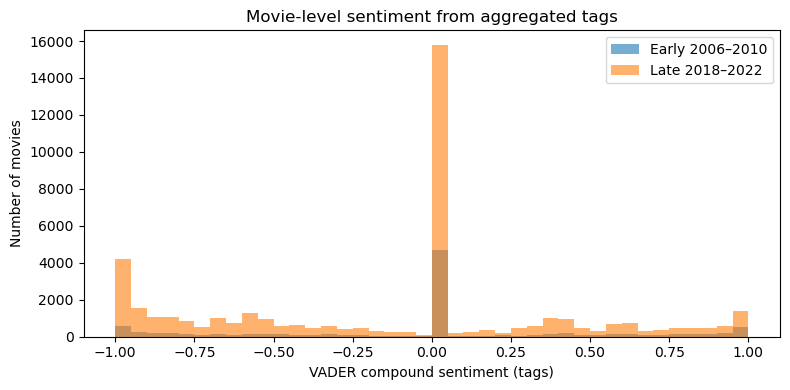

In [102]:
def summarize_sentiment(df, label):
    s = df["sent_vader"].dropna()
    print(f"\n[{label}] VADER compound sentiment summary:")
    print(s.describe(percentiles=[0.25, 0.5, 0.75]))
    return s

sent_early = summarize_sentiment(movies_early_text, "Early (2006–2010)")
sent_late = summarize_sentiment(movies_late_text, "Late (2018–2022)")

# Histograms (same binning for comparability)
bins = np.linspace(-1, 1, 41)

plt.figure(figsize=(8, 4))
plt.hist(sent_early, bins=bins, alpha=0.6, label="Early 2006–2010")
plt.hist(sent_late, bins=bins, alpha=0.6, label="Late 2018–2022")
plt.xlabel("VADER compound sentiment (tags)")
plt.ylabel("Number of movies")
plt.title("Movie-level sentiment from aggregated tags")
plt.legend()
plt.tight_layout()
plt.show()


[Early (2006–2010)] Positive movies (>= 0.5): 1,800
[Early (2006–2010)] Negative movies (<= -0.5): 2,101

[Late (2018–2022)] Positive movies (>= 0.5): 5,754
[Late (2018–2022)] Negative movies (<= -0.5): 13,267

Top 20 positive tokens — Early (2006–2010):
[('comedy', 3297), ('best', 1545), ('romance', 1368), ('funny', 858), ('adventure', 736), ('great', 715), ('good', 677), ('true', 637), ('top', 514), ('love', 487), ('thriller', 305), ('romantic', 279), ('beautiful', 255), ('hilarious', 246), ('humorous', 237), ('friendship', 230), ('supporting', 223), ('humor', 210), ('award', 204), ('whimsical', 172)]

Top 20 negative tokens — Early (2006–2010):
[('war', 1964), ('crime', 961), ('horror', 824), ('violence', 657), ('bad', 601), ('disturbing', 598), ('killer', 471), ('murder', 417), ('revenge', 377), ('tense', 298), ('violent', 270), ('death', 238), ('boring', 237), ('prison', 214), ('racism', 213), ('rape', 200), ('stupid', 199), ('illness', 193), ('scary', 171), ('apocalyptic', 158)]

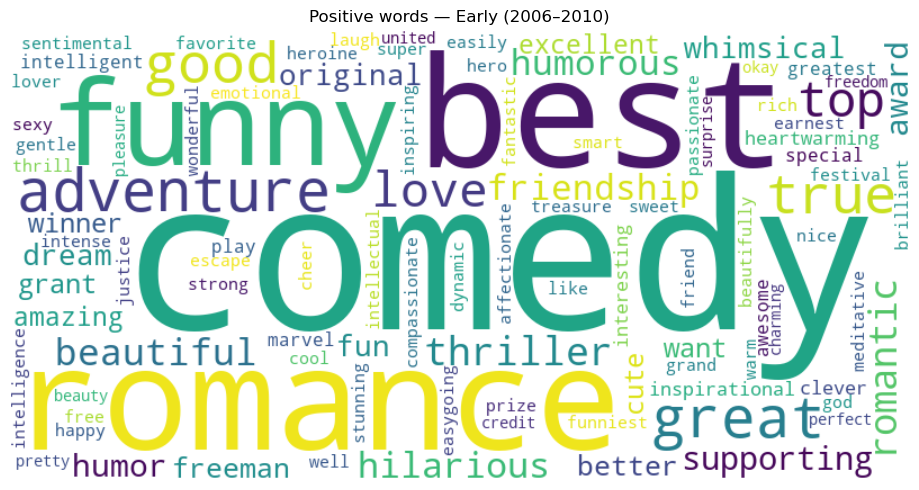

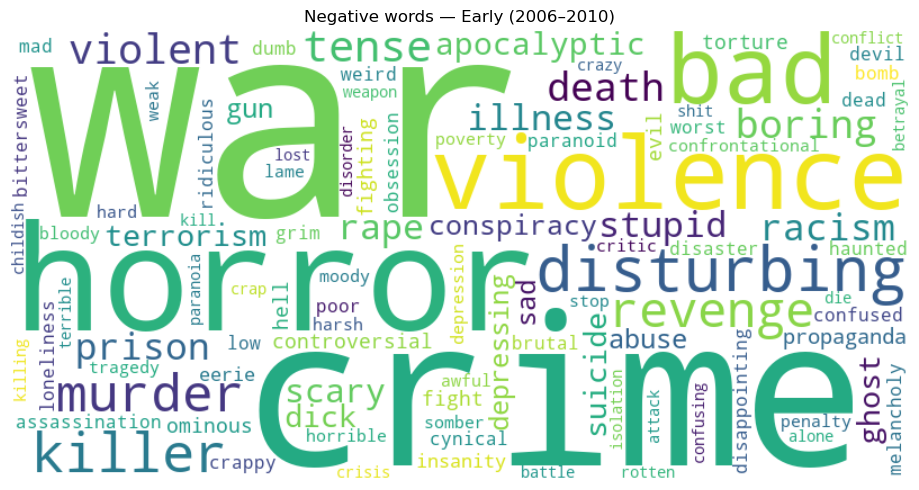

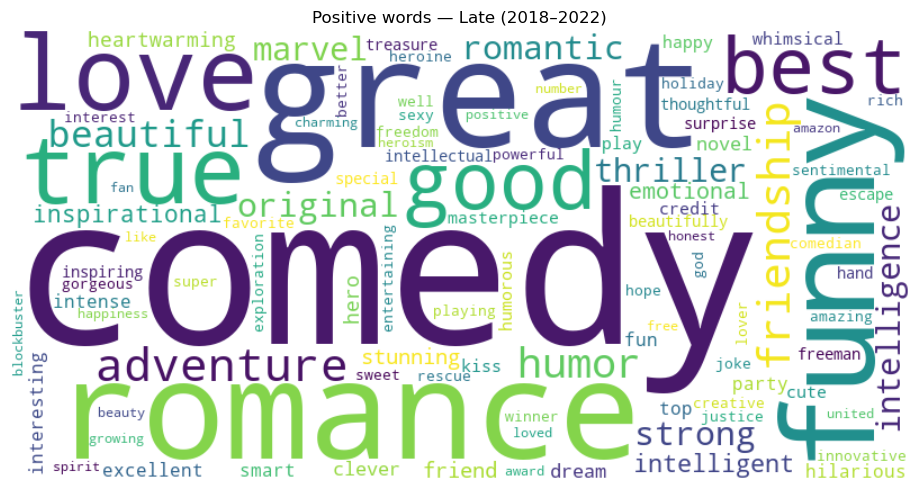

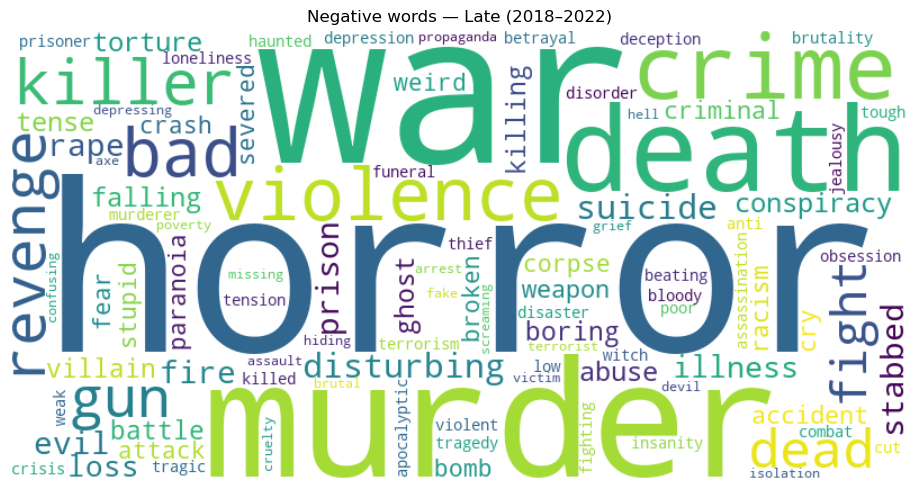

In [104]:
from wordcloud import WordCloud
vader_lexicon = sia.lexicon  # from previous VADER section

def token_valence(word):
    """Return VADER lexicon valence for a token (0.0 if unknown)."""
    return vader_lexicon.get(word, 0.0)

def build_sentiment_word_freq(
    movies_df,
    label,
    sent_col="sent_vader",
    pos_movie_thr=0.5,
    neg_movie_thr=-0.5,
    min_valence=0.2
):
    """
    Build frequency distributions of clearly positive/negative tokens
    from positive/negative movies, based on movie-level VADER scores.

    Parameters
    ----------
    movies_df : pd.DataFrame
        Must include columns ['tokens', sent_col].
    label : str
        Label for printing.
    sent_col : str
        Column with movie-level VADER compound scores.
    pos_movie_thr : float
        Threshold above which a movie is considered positive.
    neg_movie_thr : float
        Threshold below which a movie is considered negative.
    min_valence : float
        Absolute lexicon valence threshold for selecting tokens.

    Returns
    -------
    pos_fd : FreqDist
        Frequency distribution of positive tokens.
    neg_fd : FreqDist
        Frequency distribution of negative tokens.
    """
    # Select positive and negative movies
    pos_movies = movies_df[movies_df[sent_col] >= pos_movie_thr]
    neg_movies = movies_df[movies_df[sent_col] <= neg_movie_thr]

    print(f"\n[{label}] Positive movies (>= {pos_movie_thr}): {len(pos_movies):,}")
    print(f"[{label}] Negative movies (<= {neg_movie_thr}): {len(neg_movies):,}")

    # Aggregate tokens
    pos_tokens_all = [t for toks in pos_movies["tokens"] for t in toks]
    neg_tokens_all = [t for toks in neg_movies["tokens"] for t in toks]

    # Filter tokens by VADER lexicon valence
    pos_tokens = [w for w in pos_tokens_all if token_valence(w) >= min_valence]
    neg_tokens = [w for w in neg_tokens_all if token_valence(w) <= -min_valence]

    pos_fd = FreqDist(pos_tokens)
    neg_fd = FreqDist(neg_tokens)

    return pos_fd, neg_fd

def plot_wordcloud_from_fd(fd, title, max_words=100):
    """
    Plot a word cloud from a FreqDist.
    """
    if len(fd) == 0:
        print(f"[{title}] No words to display.")
        return
    freqs = dict(fd.most_common(max_words))
    wc = WordCloud(width=800, height=400, background_color="white")
    wc = wc.generate_from_frequencies(freqs)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# %% [markdown]
# ### 9.4.1 Build positive/negative token distributions per period

# %%
pos_fd_early, neg_fd_early = build_sentiment_word_freq(
    movies_early_text,
    "Early (2006–2010)",
    sent_col="sent_vader",
    pos_movie_thr=0.5,
    neg_movie_thr=-0.5,
    min_valence=0.2,
)

pos_fd_late, neg_fd_late = build_sentiment_word_freq(
    movies_late_text,
    "Late (2018–2022)",
    sent_col="sent_vader",
    pos_movie_thr=0.5,
    neg_movie_thr=-0.5,
    min_valence=0.2,
)

print("\nTop 20 positive tokens — Early (2006–2010):")
print(pos_fd_early.most_common(20))

print("\nTop 20 negative tokens — Early (2006–2010):")
print(neg_fd_early.most_common(20))

print("\nTop 20 positive tokens — Late (2018–2022):")
print(pos_fd_late.most_common(20))

print("\nTop 20 negative tokens — Late (2018–2022):")
print(neg_fd_late.most_common(20))

# %% [markdown]
# ### 9.4.2 Word clouds for positive and negative words

# %%
plot_wordcloud_from_fd(pos_fd_early, "Positive words — Early (2006–2010)")
plot_wordcloud_from_fd(neg_fd_early, "Negative words — Early (2006–2010)")

plot_wordcloud_from_fd(pos_fd_late, "Positive words — Late (2018–2022)")
plot_wordcloud_from_fd(neg_fd_late, "Negative words — Late (2018–2022)")

Using VADER sentiment scores on aggregated movie tags, we identified movies with strongly positive (compound ≥ 0.5) and strongly negative (compound ≤ −0.5) tag profiles in each period, and examined the most frequent sentiment-bearing words. The positive lexicon is relatively stable across time, centred on ‘comedy’, ‘funny’, ‘romance’, ‘love’ and quality markers like ‘great’ and ‘best’. In the late period, however, additional positive terms such as ‘original’, ‘intelligent’, ‘inspirational’ and ‘marvel’ become prominent, reflecting enthusiasm for originality and contemporary franchises. In contrast, the negative lexicon evolves more markedly. While both periods emphasise ‘war’, ‘crime’, ‘horror’, ‘violence’, ‘murder’ and ‘death’, early tags also include more generic evaluative terms (‘boring’, ‘stupid’) whereas late tags introduce a much richer vocabulary of specific violent and disturbing events (‘gun’, ‘fight’, ‘suicide’, ‘stabbed’, ‘fire’). This shift towards more fine-grained, often darker descriptors aligns with the more negative VADER score distribution in the late period, and suggests that the semantic dimensions along which users describe and attend to movies have changed over time, even if high-level genre diversity per user remains similar.


## Community-level profiles: genres, sentiment, vocabulary
 
 We now combine the semantic communities (from the TF-IDF content networks) with the movie-level text and sentiment information.


In [111]:
from IPython.display import display

# Merge movie-level text with community assignments
comm_early_df = movies_early_text.merge(movie_comm_early, on="movieId", how="inner")
comm_late_df = movies_late_text.merge(movie_comm_late, on="movieId", how="inner")

print(f"[Early] movies with community: {len(comm_early_df):,}")
print(f"[Late ] movies with community: {len(comm_late_df):,}")


[Early] movies with community: 14,485
[Late ] movies with community: 74,507


In [112]:
def build_community_summary(comm_df, label, top_k_communities=10, top_n_tokens=10, top_n_genres=5):
    """
    Build a summary table for the largest communities:
    - community ID
    - number of movies
    - mean sentiment (sent_vader)
    - top genres
    - top tokens
    """
    # Largest communities by movie count
    size_counts = comm_df["community"].value_counts()
    top_communities = list(size_counts.head(top_k_communities).index)

    rows = []
    for cid in top_communities:
        grp = comm_df[comm_df["community"] == cid]
        n_movies = len(grp)
        mean_sent = grp["sent_vader"].mean()

        # Genre distribution
        genres = [g for glist in grp["genres_list"] for g in glist]
        g_counts = Counter(genres)
        total_g = sum(g_counts.values()) or 1
        top_genres = g_counts.most_common(top_n_genres)
        top_genres_str = ", ".join(
            [f"{g} ({c/total_g:.2f})" for g, c in top_genres]
        )

        # Token distribution
        tokens = [t for toks in grp["tokens"] for t in toks]
        fd = FreqDist(tokens)
        top_tokens = fd.most_common(top_n_tokens)
        top_tokens_str = ", ".join([w for w, _ in top_tokens])

        rows.append(
            {
                "community": cid,
                "n_movies": n_movies,
                "mean_sentiment": mean_sent,
                "top_genres": top_genres_str,
                "top_tokens": top_tokens_str,
            }
        )

    summary_df = pd.DataFrame(rows).sort_values("n_movies", ascending=False)

    print(f"\n[{label}] Community summary (top {top_k_communities} by size):")
    display(summary_df)

    return summary_df

comm_summary_early = build_community_summary(comm_early_df, "Early (2006–2010)")
comm_summary_late = build_community_summary(comm_late_df, "Late (2018–2022)")


[Early (2006–2010)] Community summary (top 10 by size):


community  n_movies  mean_sentiment  \
0         87       424       -0.103401   
1         31       386        0.120538   
2          3       337       -0.030154   
3         10       317       -0.113760   
4          8       253        0.189087   
5         68       243       -0.348068   
6          2       218        0.295944   
7        117       216       -0.149691   
8         98       213       -0.196759   
9        136       204        0.052903   

                                          top_genres  \
0  Drama (0.27), Crime (0.24), Thriller (0.21), A...   
1  Romance (0.35), Drama (0.32), Comedy (0.25), C...   
2  Drama (0.35), Comedy (0.15), Romance (0.08), T...   
3  Documentary (0.52), Drama (0.15), Comedy (0.11...   
4  Comedy (0.59), Drama (0.30), Crime (0.02), Rom...   
5  War (0.34), Drama (0.34), Romance (0.08), Acti...   
6  Drama (0.44), Romance (0.16), Comedy (0.11), M...   
7  Mystery (0.28), Thriller (0.20), Drama (0.14),...   
8  Horror (0.44), Thriller (0.19), Drama (0.11), ...   
9  Musical (0.34), Comedy (0.22), Drama (0.18), R...   

                                          top_tokens  
0  drama, crime, thriller, action, comedy, romanc...  
1  romance, drama, comedy, family, crime, father,...  
2  rating, less, drama, comedy, romance, thriller...  
3  documentary, michael, moore, drama, comedy, po...  
4  comedy, drama, dark, satire, british, black, f...  
5  war, drama, romance, action, adventure, comedy...  
6  best, oscar, picture, drama, afi, actor, actre...  
7  mystery, thriller, drama, horror, crime, comed...  
8  horror, thriller, drama, bad, comedy, funny, g...  
9  musical, comedy, drama, romance, broadway, ada...


[Late (2018–2022)] Community summary (top 10 by size):


community  n_movies  mean_sentiment  \
0        110      2067       -0.096921   
1        519       720       -0.074010   
2        250       713       -0.032457   
3         66       697        0.176082   
4        336       442        0.182479   
5        194       416        0.543285   
6        361       409        0.164270   
7         57       408       -0.052369   
8        294       353       -0.690040   
9        392       345       -0.321286   

                                          top_genres  \
0  (no genres listed) (0.81), Drama (0.06), Comed...   
1  Drama (0.99), Thriller (0.00), Documentary (0....   
2  Documentary (0.92), Drama (0.04), Comedy (0.01...   
3  Comedy (0.96), Drama (0.02), Children (0.00), ...   
4  Musical (0.30), Comedy (0.22), Romance (0.17),...   
5  Comedy (0.77), Documentary (0.11), Drama (0.05...   
6  Drama (0.46), Romance (0.20), Comedy (0.17), D...   
7  Drama (0.38), Comedy (0.26), Romance (0.11), T...   
8  Drama (0.33), War (0.33), Action (0.09), Roman...   
9  Drama (0.25), Film-Noir (0.25), Crime (0.21), ...   

                                          top_tokens  
0  genre, listed, drama, comedy, documentary, rom...  
1  drama, firecracker, nietzsche, thriller, opera...  
2  documentary, shot, drama, one, continuous, fil...  
3  comedy, drama, dark, bittersweet, black, grump...  
4  musical, comedy, romance, music, based, drama,...  
5  comedy, standup, comedian, live, stand, funny,...  
6  gay, lgbt, romance, relationship, coming, dram...  
7  film, independent, drama, comedy, romance, qui...  
8  war, world, drama, history, based, true, story...  
9  noir, film, thriller, drama, crime, murder, de...

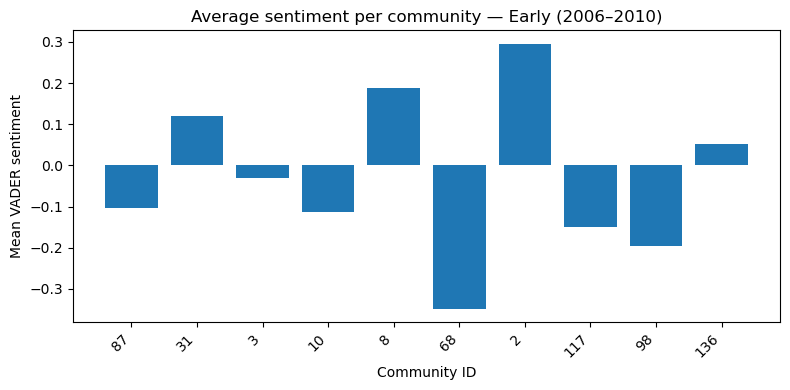

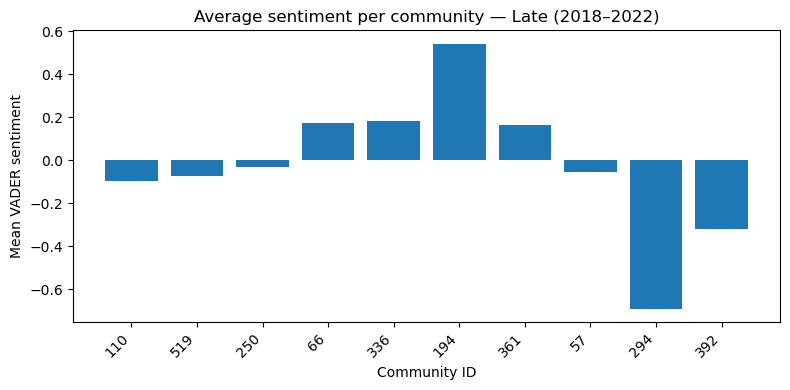

In [113]:
def plot_community_sentiment(summary_df, label):
    x = summary_df["community"].astype(str)
    y = summary_df["mean_sentiment"]

    plt.figure(figsize=(8, 4))
    plt.bar(x, y)
    plt.xlabel("Community ID")
    plt.ylabel("Mean VADER sentiment")
    plt.title(f"Average sentiment per community — {label}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plot_community_sentiment(comm_summary_early, "Early (2006–2010)")
plot_community_sentiment(comm_summary_late, "Late (2018–2022)")

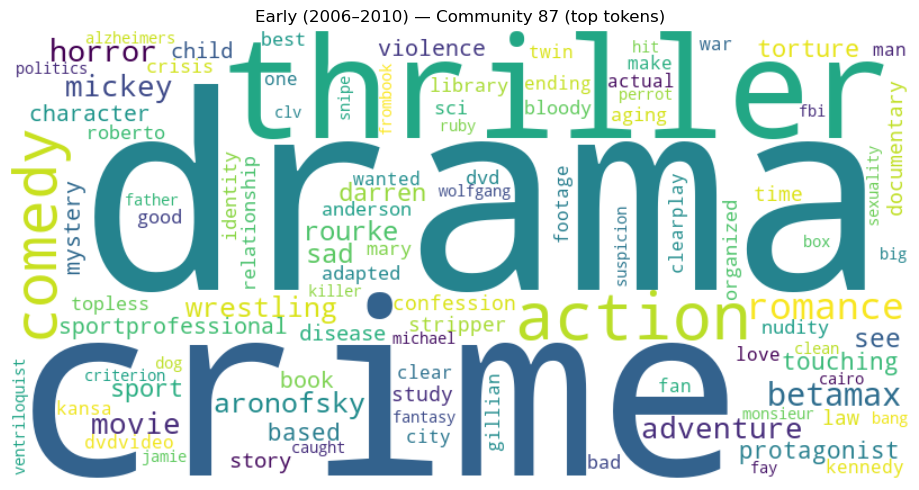

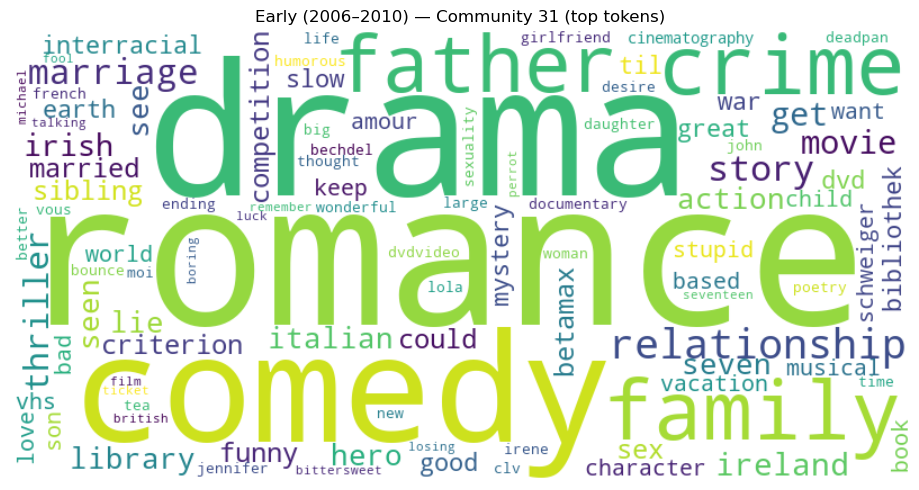

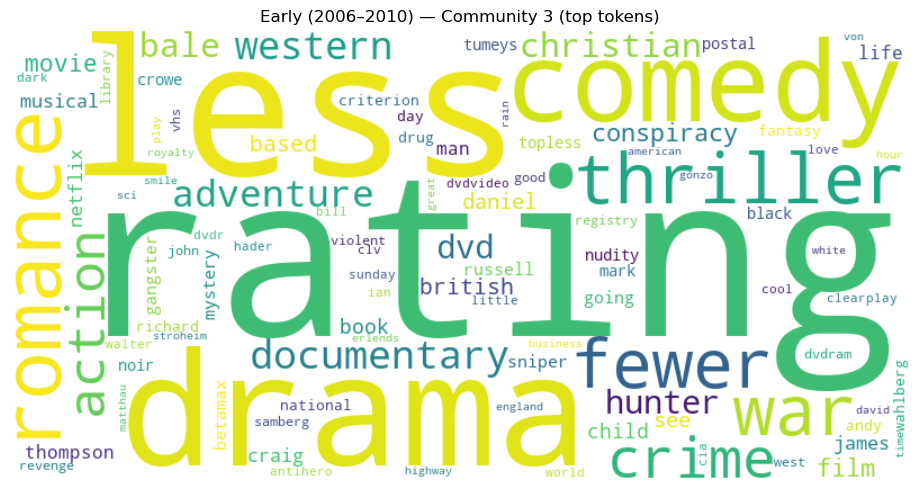

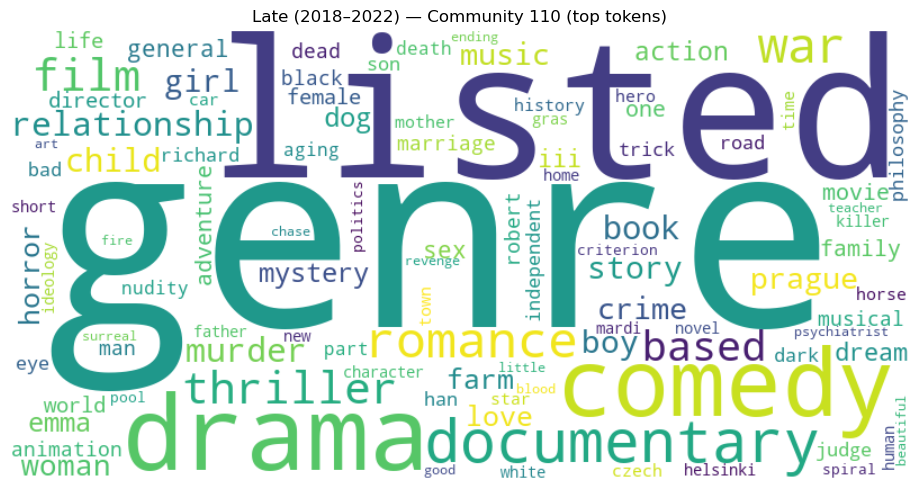

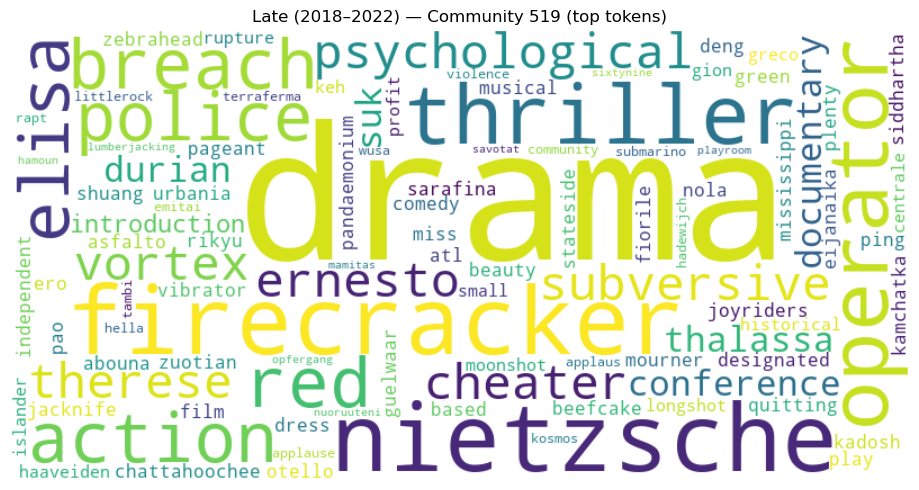

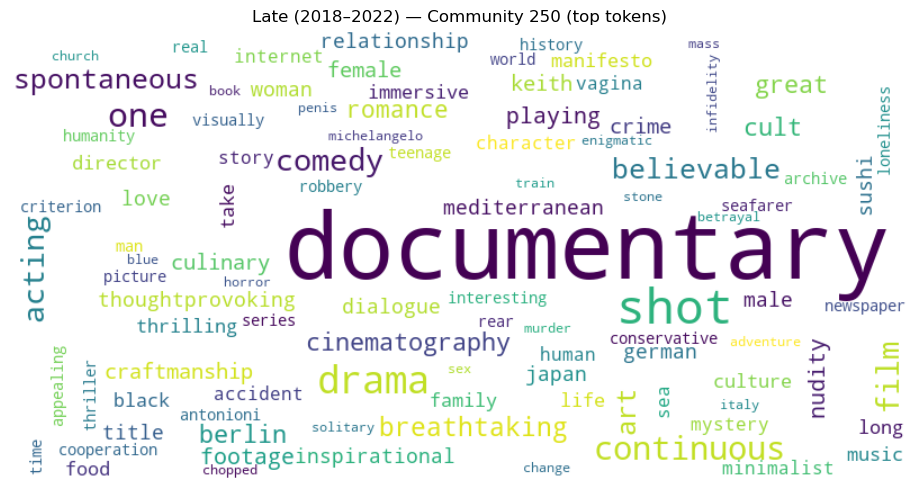

In [114]:
def plot_community_wordclouds(comm_df, summary_df, label, n_communities=3, max_words=100):
    # Take the largest n_communities
    top_comm_ids = list(summary_df.sort_values("n_movies", ascending=False)["community"].head(n_communities))
    for cid in top_comm_ids:
        grp = comm_df[comm_df["community"] == cid]
        tokens = [t for toks in grp["tokens"] for t in toks]
        if not tokens:
            continue
        fd = FreqDist(tokens)
        plot_wordcloud_from_fd(fd, f"{label} — Community {cid} (top tokens)")

plot_community_wordclouds(comm_early_df, comm_summary_early, "Early (2006–2010)")
plot_community_wordclouds(comm_late_df, comm_summary_late, "Late (2018–2022)")